#### Update for v1.1
- v1.0 was valid to work
- v1.1 added doPrediction for predict whole CT scan as in test setting. 

# Configuration

In [1]:
MODEL_TO_LOAD = ''
FN_LOSS = 0
DROPOUT = 0
PATCH_SIZE = 96
TRAINING_NAME = f'UNETR_PS{PATCH_SIZE}'
TB_PREFIX = 'bonemeta_dr_{}'.format(DROPOUT) + '_{}'.format(TRAINING_NAME)

# BATCH_SIZE = 120
BATCH_SIZE = 8
EPOCHS = 500

BASE_DIR = '/workspace/BoneMeta_all_1mm'
IMG_FOLDER_NAME = 'images'
LABEL_FOLDER_NAME = 'labels'
WHICH_CENTER = '1mm Resized Center' # 'Original Center'
DATAINFO_DIR = '/workspace/DataInfo'
DATAINFO_FILE = 'data_info_V_2022_04_27.csv'

In [2]:
import os
import sys
import hashlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import SimpleITK as sitk
import random
from monai.networks.nets import UNETR
from monai.inferers import sliding_window_inference

# Set dataset

In [3]:
# !git clone https://github.com/JungOhLee/bonemeta_model.git ./git_clone
# !mv  -v ./git_clone/* .

In [4]:
IMG_DIR = os.path.join(BASE_DIR, IMG_FOLDER_NAME)
LABEL_DIR = os.path.join(BASE_DIR, LABEL_FOLDER_NAME)

IMG_FILES = os.listdir(IMG_DIR)
LABEL_FILES = os.listdir(LABEL_DIR)

def get_img_path(file): 
    return os.path.join(IMG_DIR, file)

def get_label_path(file):
    return os.path.join(LABEL_DIR, file)

def case_to_file(case):
    return case+'.npy'

def file_to_case(file_name):
    return file_name.split('.')[0]

set(IMG_FILES).issubset(LABEL_FILES)

True

In [5]:
print(IMG_DIR, len(IMG_FILES))
print(LABEL_DIR, len(LABEL_FILES))

/workspace/BoneMeta_all_1mm/images 317
/workspace/BoneMeta_all_1mm/labels 317


In [6]:
len(set(IMG_FILES)-set(LABEL_FILES))

0

In [7]:
TRAIN_FILES = ['000021_20181227_Chest_CT_(contrast).npy', '000022_20180830_Chest_CT_(contrast).npy', '000025_20180808_CT_Abdomen+Pelvis_Dynamic_(contrast).npy', '000025_20180808_Chest_CT_(contrast).npy', '000080_20180911_Chest_CT_(contrast).npy', '000085_20180829_Chest_CT_(contrast).npy', '000162_20180131_Chest_CT_(contrast).npy', '000224_20190228_Chest_CT_(contrast).npy', '000234_20190401_CT_Abdomen+Pelvis_Dynamic_(contrast).npy', '000234_20190419_Chest_CT_(contrast).npy', '000242_20190409_Chest_CT_(contrast).npy', '000255_20190418_Chest_CT_(contrast).npy', '000262_20190318_Chest_CT_(contrast).npy', '000262_20190319_CT_Abdomen+Pelvis_Dynamic_(contrast).npy', '000262_20190529_Chest_CT_(contrast).npy', '000262_20190501_CT_Abdomen+Pelvis_Post_(contrast).npy', '000269_20190325_CT_Abdomen+Pelvis_Dynamic_(contrast).npy', '000269_20181016_CT_Abdomen+Pelvis_Dynamic_(contrast).npy', '000269_20181214_CT_Abdomen+Pelvis_Dynamic_(contrast).npy', '000269_20190601_CT_Abdomen+Pelvis_Dynamic_(contrast).npy', '000270_20190608_Chest_CT_(contrast).npy', '000276_20190604_Chest_CT_(contrast).npy', '000279_20190614_Chest_3DCT_(contrast).npy', '000281_20190701_Chest_CT_(contrast).npy', '000282_20190410_CT_Abdomen+Pelvis_Dynamic_(contrast).npy', '000282_20190701_CT_Abdomen+Pelvis_Post_(contrast).npy', '000291_20190701_CT_Abdomen+Pelvis_Dynamic_(contrast).npy', '000291_20190718_Chest_CT_(contrast).npy', '000296_20190726_Chest_CT_(contrast).npy', '000301_20190827_Chest_CT_(contrast).npy', '000301_20190801_CT_Acute_Abdomen_(contrast).npy', '000302_20190726_Chest_CT_(contrast).npy', '000304_20190124_CT_Liver_(contrast).npy', '000308_20190826_Chest_CT_(contrast).npy', '000309_20190801_CT_Abdomen+Pelvis_Dynamic_(contrast).npy', '000309_20190823_Chest_CT_(contrast).npy', '000311_20190902_Chest_CT_(contrast).npy', '000322_20190913_Chest_CT_(contrast).npy', '000322_20190901_CT_Abdomen+Pelvis_Dynamic_(contrast).npy', '000325_20190919_Chest_CT_(contrast).npy', '000330_20190926_Chest_CT_(contrast).npy', '000332_20191001_CT_Abdomen+Pelvis_Dynamic_(contrast).npy', '000344_20191125_Chest_CT_(contrast).npy', '000352_20191001_CT_Abdomen+Pelvis_Dynamic_(contrast).npy', '000352_20191017_Chest_CT_(contrast).npy', '000354_20191022_Chest_CT_(contrast).npy', '000354_20191001_CT_Abdomen+Pelvis_Post_(contrast).npy', '000355_20190901_CT_Abdomen+Pelvis_Dynamic_(contrast).npy', '000355_20191023_Chest_CT_(contrast).npy', '000356_20190901_CT_Abdomen+Pelvis_Dynamic_(contrast).npy', '000356_20191024_Chest_CT_(contrast).npy', '000362_20191214_Chest_CT_(contrast).npy', '000362_20191201_CT_Abdomen+Pelvis_Dynamic_(contrast).npy', '000363_20191222_Chest_3DCT_(contrast).npy', '000363_20191201_CT_Abdomen+Pelvis_Pre-Post_(contrast).npy', '000364_20191217_Chest_CT_(contrast).npy', '000368_20200101_CT_Abdomen+Pelvis_Dynamic_(contrast).npy', '000372_20200101_CT_Abdomen+Pelvis_Dynamic_(contrast).npy', '000376_20200114_Chest_CT_(contrast).npy', '000376_20200101_CT_Abdomen+Pelvis_Dynamic_(contrast).npy', '000386_20200204_Chest_CT_(contrast).npy', '000404_20200305_Chest_CT_(contrast).npy', '000404_20200201_CT_Abdomen+Pelvis_Dynamic_(contrast).npy', 'BH008_20190701_Chest_CT_(contrast)_+_3D_(Chest_with_other_CT).npy', 'BH008_20190701_Abdomen_&_pelvis_CT_(3D).npy', 'BH009_20180301_Abdomen_&_pelvis_CT_(3D).npy', 'BH009_20180301_Chest_CT_(contrast)_+_3D_(TS_with_other_CT).npy', 'BH010_20161101_Chest_CT_(contrast)_+_3D_(Breast_with_other_CT).npy', 'BH010_20161101_Abdomen_&_pelvis_CT_(3D).npy', 'BH012_20180401_Abdomen_&_pelvis_CT_(3D).npy', 'BH012_20180401_Chest_CT_(contrast)_+_3D_(Chest_with_other_CT).npy', 'BH013_20191001_Chest_CT_(contrast)_+_3D_(Chest_with_other_CT).npy', 'BH014_20181201_Abdomen_&_pelvis_CT_(3D).npy', 'BH014_20181201_Chest_CT_(contrast)_+_3D_(Chest_with_other_CT).npy', 'BH015_20190101_Chest_CT_(contrast)_+_3D_(Breast_with_other_CT).npy', 'BH015_20190101_Abdomen_&_pelvis_CT_(3D).npy', 'BH016_20151001_Chest_CT_(contrast)_+_3D_(Chest_with_other_CT).npy', 'BH016_20151001_Abdomen_&_pelvis_CT_(3D).npy', 'BH017_20191201_Chest_CT_(contrast)_+_3D_(Chest_with_other_CT).npy', 'BH017_20191201_Abdomen_&_pelvis_CT_(3D).npy', 'BH019_20191101_Thorax^02_Chest_CON_(Adult).npy', 'BH020_20191201_Chest_CT_(Non_contrast)_+_3D.npy', 'BH022_20190101_Thorax^03_Chest_NON_(Adult).npy', 'BH023_20191101_Abdomen_&_pelvis_CT_(3D).npy', 'BH023_20191101_Chest_CT_(contrast)_+_3D_(Chest_with_other_CT).npy', 'BH026_20190601_Abdomen_&_pelvis_CT_(3D).npy', 'BH028_20190801_Chest_CT_(contrast)_+_3D.npy', 'BH029_20200101_Chest_HRCT_(lung_cancer).npy', 'BH031_20160301_CT_Angio_+_3D_Pulmonary_artery_(Embolism).npy', 'BH032_20180701_Chest_CT_(contrast)_+_3D_(Breast_with_other_CT).npy', 'BH034_20190901_Chest_CT_(contrast)_+_3D_(Chest_with_other_CT).npy', 'BH034_20190923_GU_OBGY,Abd-pelvis_CT(pre&post)_(3D).npy', 'BH035_20191101_GU_Kidney_&_bladder_CT_(3D).npy', 'BH036_20180301_GU_Kidney_&_bladder_CT_(3D).npy', 'BH043_20191001_Chest_CT_(contrast)_+_3D_(Chest_with_other_CT).npy', 'BH043_20191001_Abdomen_&_pelvis_CT_(3D).npy', 'BH045_20181001_Chest_CT_(contrast)_+_3D_(Chest_with_other_CT).npy', 'BH047_20180901_Abdomen_&_pelvis_CT_(3D).npy', 'BH048_20190501_Chest_CT_(contrast)_+_3D_(Breast_with_other_CT).npy', 'BH051_20190301_GU_Kidney_&_bladder_CT_(3D).npy', 'BH054_20191122_Abdomen^00_Liver_CT_(Adult).npy', 'BH055_20200328_Chest_CT_(contrast)_+_3D_(Chest_with_other_CT).npy', 'BH056_20200721_Chest_CT_(contrast)_+_3D.npy', 'BH057_20191227_Chest_CT_(contrast)_+_3D_(Chest_with_other_CT).npy', 'BH057_20191227_Abdomen_&_pelvis_CT_(3D).npy', 'BH058_20180918_Chest_CT_(contrast)_+_3D.npy', 'BH059_20201013_Abdomen_&_pelvis_CT.npy', 'BH064_20200605_Chest_CT_(contrast)_+_3D_(Chest_with_other_CT).npy', 'BH064_20200605_Abdomen_&_pelvis_CT_(3D).npy', 'BH066_20190525_Chest_CT_(contrast)_+_3D_(Chest_with_other_CT).npy', 'BH067_20191017_Chest_CT_(contrast)_+_3D_(Chest_with_other_CT).npy', 'BH069_20200505_Chest_CT_(contrast)_+_3D.npy', 'BH081_20190322_Abdomen_&_pelvis_CT_(3D).npy', 'BH081_20190322_Chest_CT_(contrast)_+_3D_(Chest_with_other_CT).npy', 'BH112_20190201_Chest_CT_(contrast)_+_3D_(Chest_with_other_CT).npy', 'BH112_20190201_Abdomen_&_pelvis_CT_(3D).npy', 'SN002_20190801_CT_Chest_+_3D_(contr.npy', 'SN005_20191001_Abdomen^03_LIVER_(Adult).npy', 'SN005_20191101_CT_Chest_+_3D_(contr.npy', 'SN007_20190701_Thorax^05_Chest_Lung_Cancer_3D_(Adult).npy', 'SN012_20150801_Abdomen^01_Abdomen_Pelvis_Chest_(Adult).npy', 'SN025_20200401_CT_Chest_+_3D_(contr.npy', 'SN028_20160801_CT_Chest_+_3D_(contrast).npy', 'SN028_20160801_CT_Abdomen+Pelvis_3D_(contrast).npy', 'SN036_20190601_CT_Chest_+_3D_(contr.npy', 'SN042_20170901_CT_Chest_+_3D_(contr.npy', 'SN042_20170901_CT_Abdomen+Pelvis_3D.npy', 'SN051_20170401_CT_Abdomen+Pelvis_Arterial+Portal_(contrast).npy', 'SN051_20170401_CT_Chest_+_3D_(contrast_NO_CM).npy', 'SN054_20170201_CT_Chest_Lung_cancer+3D(contrast).npy', 'SN055_20170301_CT_Chest_Low_Dose_+.npy']\
 + ['000010_20181214_CT_Abdomen+Pelvis_Dynamic_(contrast).npy', '000370_20200101_CT_Abdomen+Pelvis_Post_(contrast).npy', '000370_20200117_Chest_CT_(contrast).npy', '000409_20200310_Chest_CT_(contrast).npy', '000409_20200301_CT_Biliary_(contrast).npy', '000417_20200331_Chest_CT_(contrast).npy', '000423_20200401_CT_Abdomen+Pelvis_Dynamic_(contrast).npy', '000423_20200407_Chest_CT_(contrast).npy', '000424_20200312_Chest_CT_(noncontrast).npy', '000424_20200218_Chest_CT_(contrast).npy', '000435_20200420_Chest_CT_(contrast).npy', '000435_20200401_CT_Abdomen+Pelvis_Dynamic_(contrast).npy', '000466_20210125_Chest_CT_(contrast).npy', '000466_20210128_CT_Abdomen+Pelvis_Post_(contrast).npy', '000475_20210210_Chest_CT_(contrast).npy', '000481_20210305_Thorax^Lung_Pre_(Adult).npy', '000481_20200722_Chest_CT_(noncontrast).npy', '000481_20210409_CT_Liver_(contrast).npy', '000492_20210401_CT_Abdomen+Pelvis_Pre-Post_(contrast).npy', '000494_20210405_Chest_CT_(contrast).npy', '000506_20201113_Chest_CT_(contrast).npy', '000506_20201110_CT_Urography_(contrast).npy', '000528_20210514_Chest_CT_(contrast).npy', '000530_20210428_Chest_CT_(contrast).npy', '000533_20210507_CT_Liver_(contrast).npy', '000541_20210520_Chest_CT_(contrast).npy', '000557_20210621_CT_Abdomen+Pelvis_Post_(contrast).npy', '000557_20210621_Chest_CT_(contrast).npy', '000560_20210706_CT_Abdomen+Pelvis_Dynamic_(contrast).npy', '000560_20210706_Chest_CT_(contrast).npy', 'BH037_20171125_Chest_CT_(contrast)_+_3D_(Chest_with_other_CT).npy', 'BH037_20171125_Abdomen_&_pelvis_CT_(3D).npy', 'BH071_20160826_Chest_CT_(contrast)_+_3D.npy', 'BH073_20201223_Chest_CT_(contrast)_+_3D_(Chest_with_other_CT).npy', 'BH073_20201223_Abdomen_&_pelvis_CT.npy', 'BH074_20201113_Abdomen^00_Abd_CT_(Adult).npy', 'BH075_20200721_Chest_CT_(Contrast)_+_3D(Breast).npy', 'BH076_20180605_Chest_CT_(contrast)_+_3D_(Chest_with_other_CT).npy', 'BH076_20180605_GU_Abdomen_&_pelvis_CT_(3D).npy', 'BH078_20200522_Abdomen_&_pelvis_CT_(3D).npy', 'BH079_20200921_Low_dose_Chest_CT_+_3D(insured).npy', 'BH080_20181210_Abdomen_&_pelvis_CT_(3D).npy', 'BH082_20200416_Chest_CT_(contrast)_+_3D.npy', 'BH085_20200801_Abdomen_&_pelvis_CT.npy', 'BH086_20190812_Chest_CT_(Contrast)_+_3D(TS).npy', 'BH087_20190314_Abdomen_&_pelvis_CT_(3D).npy', 'BH089_20200811_Abdomen_&_pelvis_CT.npy', 'BH089_20200803_Chest_CT_(Contrast)_+_3D(TS).npy', 'BH090_20200924_Abdomen_&_pelvis_CT.npy', 'BH095_20200727_Abdomen_&_pelvis_CT_(3D).npy', 'BH098_20200626_Chest_CT_(contrast)_+_3D_(Chest_with_other_CT).npy', 'BH098_20200626_GU_Kidney_&_bladder_CT_(3D).npy', 'BH100_20201007_Thorax^02_Chest_CON_(Adult).npy', 'BH101_20201109_Chest_CT_(Contrast)_+_3D(TS).npy', 'BH104_20161219_Abdomen_&_pelvis_CT_(3D).npy', 'BH104_20161219_Chest_CT_(contrast)_+_3D_(Chest_with_other_CT).npy', 'BH105_20160820_Chest_CT_(contrast)_+_3D.npy', 'BH106_20200613_Chest_CT_(contrast)_+_3D_(Breast_with_other_CT).npy', 'BH106_20200613_Abdomen_&_pelvis_CT_(3D).npy', 'BH107_20200510_Chest_CT_(Contrast)_+_3D(TS).npy', 'BH108_20180223_Liver_CT_(LC_or_CLD,_3D).npy', 'BH108_20180228_Chest_CT_(contrast)_+_3D.npy', 'BH109_20181210_Chest_CT_(contrast)_+_3D_(Breast_with_other_CT).npy', 'BH111_20161020_CT_Angio_+_3D_Coronary,_Chest.npy', 'BH113_20170914_Liver_CT_(LC_or_CLD,_3D).npy', 'BH114_20180920_Chest_CT_(contrast)_+_3D_(Chest_with_other_CT).npy', 'BH114_20180920_GU_Kidney_&_bladder_CT_(3D).npy', 'BH116_20180606_Chest_CT_(contrast)_+_3D_(Breast_with_other_CT).npy', 'BH116_20180606_GU_Abdomen_&_pelvis_CT_(3D).npy', 'BH117_20180506_Abdomen_&_pelvis_CT_(3D).npy', 'BH117_20180506_Chest_CT_(contrast)_+_3D_(Chest_with_other_CT).npy', 'BH118_20200617_Liver_CT_(LC_or_CLD,_3D).npy', 'BH118_20200702_Chest_CT_(contrast)_+_3D.npy', 'BH119_20200303_Abdomen_&_pelvis_CT_(3D).npy', 'BH119_20200227_Chest_CT_(contrast)_+_3D.npy', 'BH120_20200406_Chest_CT_(contrast)_+_3D_(Chest_with_other_CT).npy', 'BH120_20200406_Abdomen_&_pelvis_CT_(3D).npy', 'BH120_20200304_Chest_CT_(contrast)_+_3D.npy', 'BH121_20200301_Chest_CT_(contrast)_+_3D_(Chest_with_other_CT).npy', 'BH121_20200301_Abdomen_&_pelvis_CT_(3D).npy', 'BH123_20201023_Abdomen_&_pelvis_CT.npy', 'BH123_20201023_Chest_CT_(contrast)_+_3D_(Chest_with_other_CT).npy', 'KH001_20210501_Chest(+).npy', 'KH002_20210301_Abdomen^00_AbdomenRoutine_(Adult).npy', 'KH002_20210301_Thorax^00_Fl_Chest_Routine_(Adult).npy', 'KH007_20200601_Chest(+).npy', 'KH007_20200601_Chest(+)_+_Abdomen_&_Pelvis_(+).npy', 'KH009_20200801_Chest(+).npy', 'KH009_20200801_Chest(+)_+_Abdomen_&_Pelvis_(+).npy', 'KH010_20201201_Chest(+).npy', 'KH010_20201201_Chest(+)_+_Abdomen_&_P.npy', 'KH014_20190701_Chest(+).npy', 'KH014_20190701_IM_Chest(+)_+_Abdomen_&_Pelvis_(+).npy', 'KH016_20191101_Chest(+).npy', 'KH016_20191101_Chest(+)_+_Abdomen_&_Pelvis(+).npy', 'KH023_20210901_Chest(+).npy', 'KH024_20211001_Chest(+).npy', 'KH025_20211001_Chest(+).npy', 'KH026_20210801_Chest(+).npy', 'KH027_20210801_Chest(+).npy', 'KH028_20210401_Thorax^00_Fl_Chest_Routine_(Adult).npy', 'KH030_20210901_Chest_Low-Dose_Screeni.npy', 'KH031_20210801_Chest(+).npy', 'KH032_20210701_Chest(+).npy', 'KH033_20210701_Chest(+).npy', 'KH036_20210401_Chest(+).npy', 'KH037_20210401_Chest(+).npy', 'KH038_20210401_Chest(+).npy', 'KH039_20210301_Chest_(-)_Routine.npy', 'KH040_20210301_Chest(+).npy', 'KH042_20210501_Chest(+).npy', 'KH043_20210601_Thorax^00_Fl_Chest_Routine_(Adult).npy']
VAL_FILES = ['000232_20190401_CT_Abdomen+Pelvis_Dynamic_(contrast).npy', '000232_20190423_Chest_CT_(contrast).npy', '000285_20190801_CT_Abdomen+Pelvis_Pre-Post_(contrast).npy', '000285_20190807_Chest_CT_(contrast).npy', '000316_20190627_Chest_CT_(contrast).npy', '000316_20190715_Spine^L_SPINE_(Adult).npy', 'BH006_20170801_Chest_CT_(Contrast)_+_3D(Breast).npy', 'BH027_20191001_Chest_CT_(Contrast)_+_3D(TS).npy', 'BH027_20191001_L-spine_CT_(3D).npy', 'BH040_20200101_CT_Angio_+_3D_Pulmonary_artery_(Embolism).npy', 'BH060_20200413_Chest_CT_(contrast)_+_3D.npy', 'BH062_20201104_Chest_CT_(contrast)_+_3D_(Chest_with_other_CT).npy', 'BH065_20201013_Low_dose_Chest_CT_+_3D(insured).npy', 'BH099_20200806_Chest_CT_(contrast)_+_3D_(Chest_with_other_CT).npy', 'BH099_20200806_Abdomen_&_pelvis_CT.npy', 'BH110_20200616_Chest_CT_(contrast)_+_3D_(Chest_with_other_CT).npy', 'SN004_20190901_CT_Chest_+_3D_(contrast).npy', 'SN017_20190701_Thorax^05_Chest_Lung_Cancer_3D_(Adult).npy', 'SN035_20180101_CT_Stomach+Pelvis_Arterial+Portal(contrast).npy', 'SN056_20170601_Thorax^01_Lung_Cancer_3D_(Adult).npy', '000019_20181018_Chest_CT_(contrast).npy', '000019_20190613_Chest_CT_(contrast).npy', '000019_20190601_CT_Abdomen+Pelvis_Dynamic_(contrast).npy', '000193_20190114_Chest_CT_(contrast).npy', '000251_20190429_Chest_CT_(contrast).npy', '000251_20190429_CT_Abdomen+Pelvis_Dynamic_(contrast).npy', '000251_20190701_CT_Abdomen+Pelvis_Dynamic_(contrast).npy', '000251_20190703_Chest_CT_(contrast).npy', '000286_20190701_CT_Abdomen+Pelvis_Dynamic_(contrast).npy', '000286_20190710_[외부_CT_19-07-10]Chest_CT_contrast.npy', '000288_20190701_CT_Abdomen+Pelvis_Dynamic_(contrast).npy', '000450_20200528_CT_Abdomen+Pelvis_Post_(contrast).npy', '000450_20200512_Chest_CT_(contrast).npy', 'BH021_20181001_Chest_CT_(contrast)_+_3D_(Chest_with_other_CT).npy', 'BH021_20181001_Abdomen_&_pelvis_CT_(3D).npy', 'BH024_20190501_Chest_CT_(contrast)_+_3D_(Breast_with_other_CT).npy', 'BH024_20190501_Abdomen_&_pelvis_CT_(3D).npy', 'BH052_20190901_Abdomen_&_pelvis_CT_(3D).npy', 'BH052_20190901_Chest_CT_(contrast)_+_3D_(Chest_with_other_CT).npy', 'SN016_20190901_CT_Chest_+_3D_(contr.npy', 'SN016_20190901_CT_Abdomen+Pelvis_Ar.npy']
TEST_FILES = ['000011_20181207_Chest_CT_(contrast).npy', '000011_20181207_CT_Abdomen+Pelvis_Post_(contrast).npy', '000048_20190501_CT_Abdomen+Pelvis_Uro_(contrast).npy', '000069_20180319_Chest_CT_(contrast).npy', '000079_20180911_Pulmonary_artery_CT_Angio+3D_(contrast).npy', '000212_20190324_Chest_CT_(noncontrast).npy', '000260_20190501_CT_Liver_(contrast).npy', '000260_20190522_Chest_CT_(contrast).npy', '000272_20190601_CT_Abdomen+Pelvis_Dynamic_(contrast).npy', '000272_20190614_Chest_CT_(contrast).npy', '000278_20190620_Chest_CT_(contrast).npy', '000298_20190726_Chest_CT_(contrast).npy', '000305_20190801_CT_Acute_Abdomen_(contrast).npy', '000391_20200216_Thoracic_Aorta_CT_Angio+3D_(contrast).npy', '000400_20200210_Chest_CT_(contrast).npy', '000400_20200201_CT_Biliary_(contrast).npy', 'BH001_20190501_Abdomen_&_pelvis_CT_(3D).npy', 'BH002_20190701_Chest_CT_(Non_contrast)_+_3D.npy', 'BH005_20170701_Abdomen_&_pelvis_CT_(3D).npy', 'BH005_20170707_Chest_CT_(contrast)_+_3D_(Breast_with_other_CT).npy', 'BH007_20190801_Abdomen_&_pelvis_CT_(3D).npy', 'BH007_20190801_Chest_CT_(contrast)_+_3D_(Chest_with_other_CT).npy', 'BH061_20190315_Abdomen_&_pelvis_CT_(3D).npy', 'BH061_20190315_Chest_CT_(contrast)_+_3D_(Chest_with_other_CT).npy', 'BH063_20200519_Chest_CT_(Non_contrast)_+_3D(Breast).npy', 'BH070_20160823_Abdomen_&_pelvis_CT_(3D).npy', 'BH070_20160823_Chest_CT_(contrast)_+_3D_(Chest_with_other_CT).npy', 'BH091_20200104_Chest_CT_(contrast)_+_3D_(Chest_with_other_CT).npy', 'BH091_20200104_GU_Kidney_&_bladder_CT_(3D).npy', 'SN019_20190801_CT_Chest_+_3D_(contr.npy', 'SN019_20190801_CT_Abdomen+Pelvis_Ar.npy', 'SN031_20160501_CT_Abdomen+Pelvis_Ar.npy', 'SN031_20160501_2-CT_Chest_Lung_cancer.npy']


# EXCEPTIONS = ['BH040_20200101_CT Angio + 3D Pulmonary artery (Embolism).npy', 'BH040_20200101_CT Angio + 3D Pulmonary artery (Embolism) (2).npy'] # 모델에서 data info 만들때 가끔 오류남.
EXCEPTIONS = '''000273_20190531_Chest_CT_(contrast).npy
000439_20200624_Chest_CT_(contrast).npy
000557_20210621_Chest_CT_(contrast).npy
BH002_20190701_Chest_CT_(Non_contrast)_+_3D.npy
BH091_20200104_Chest_CT_(contrast)_+_3D_(Chest_with_other_CT).npy
BH091_20200104_Chest_CT_(contrast)_+_3D_(Chest_with_other_CT).npy
000350_20191001_CT_Abdomen+Pelvis_Dynamic_(contrast).npy
000352_20191017_Chest_CT_(contrast).npy
000354_20191022_Chest_CT_(contrast).npy
000391_20200216_Thoracic_Aorta_CT_Angio+3D_(contrast).npy
BH027_20191001_L-spine_CT_(3D).npy
000270_20190601_CT_Abdomen+Pelvis_Dynamic_(contrast).npy
000270_20190608_Chest_CT_(contrast).npy
BH040_20200101_CT_Angio_+_3D_Pulmonary_artery_(Embolism).npy
BH118_20200617_Liver_CT_(LC_or_CLD,_3D).npy
000424_20200312_Chest_CT_(noncontrast).npy
000424_20200218_Chest_CT_(contrast).npy
000325_20190919_Chest_CT_(contrast).npy
BH069_20200505_Chest_CT_(contrast)_+_3D.npy'''.split('\n')

TRAIN_FILES = list(set(TRAIN_FILES).intersection(set(IMG_FILES)) - set(EXCEPTIONS))
VAL_FILES = list(set(VAL_FILES).intersection(set(IMG_FILES)) - set(EXCEPTIONS))
TEST_FILES = list(set(TEST_FILES).intersection(set(IMG_FILES)) - set(EXCEPTIONS))

# TRAIN_FILES = TRAIN_FILES[:50]
# VAL_FILES = VAL_FILES[:15]

In [8]:
print(f'''
train: {len(TRAIN_FILES)}
val: {len(VAL_FILES)}
test: {len(TEST_FILES)}
total: {len(TRAIN_FILES + VAL_FILES + TEST_FILES)}
''')


train: 234
val: 39
test: 30
total: 303



In [9]:
def adjust_window(image, window):
    width = window[0]
    level = window[1]
    upper = level+width/2
    lower = level-width/2
    copied_image = image.clip(lower, upper)
    copied_image = copied_image-lower
    return (copied_image/(upper-lower))

# Set dataloader

In [10]:
import torch 
import numpy as np
from joblib import Parallel, delayed
import time

In [11]:
import os, glob
import pandas as pd
import numpy as np
from joblib import Parallel, delayed

import torch
from torch.utils.data import Dataset, DataLoader
from augmentation import get_transform

    
class TrainDataset(Dataset):
    def __init__(self, case_files=None, patch_size=PATCH_SIZE, trans_x=0.2, trans_y=0.2, trans_z=0.2):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.patch_size = patch_size
        self.trans_x, self.trans_y, self.trans_z = trans_x, trans_y, trans_z

        self.case_files = case_files
        self.data_info = self.get_data_info()
        self.images = [np.load(get_img_path(file)) for file in case_files]
        self.labels = [np.load(get_label_path(file)) for file in case_files]
        self.windows = [(500,200), (700,400), (1200,400)]

    def get_data_info(self):
        all_data_info = pd.read_csv(f'{DATAINFO_DIR}/{DATAINFO_FILE}')
        case_tuple = tuple([file_to_case(file) for file in self.case_files])
        include_idx = all_data_info.Case.str.startswith(case_tuple)
        partial_data_info = all_data_info.loc[include_idx]
        if 'Data' in partial_data_info.columns:
            return partial_data_info.drop('Data', axis=1).drop_duplicates()
        else: 
            return partial_data_info.drop_duplicates()
        
    def __len__(self):
        return int(len(self.data_info)*2)
    
    def __getitem__(self, idx):
        if idx % 2 == 0: 
            return self.get_lesion_crop(idx//2)
        else: 
            return self.get_random_crop()
#             return self.get_lesion_crop(idx//2)

    def get_lesion_crop(self, idx):
        lesion_data = self.data_info.iloc[idx]
        center = lesion_data[WHICH_CENTER][1:-1].split(', ')
        center = self.change_to_pytorch_coord(center)
        patch_image, patch_label = self.crop_patch(lesion_data['Case'], center)
        result = self.process_patch(patch_image, patch_label)
        return result
    
    def get_random_crop(self):
        case_idx = np.random.randint(0, len(self.images))
        image, label = self.images[case_idx], self.labels[case_idx]
        # 이 부분에서 z축이 patch_size보다 작으면 에러남
        z, r, c = [np.random.randint(0, shape - self.patch_size) for shape in image.shape]
        patch_image = image[z:z+self.patch_size, r:r+self.patch_size, c:c+self.patch_size]
        patch_label = label[z:z+self.patch_size, r:r+self.patch_size, c:c+self.patch_size]
        return self.process_patch(patch_image, patch_label)
    
    def process_patch(self, patch_image, patch_label):
#         patch_image, patch_label = torch.tensor(patch_image, dtype=torch.float32), torch.tensor(patch_label, dtype=torch.bool)
#         return self.convert_to_multi_channel_img(patch_image, self.windows), patch_label
        augmentation_dict={'flip': True, 'scale':0.2, 'rotate':True,'noise': 0.1}
        transformed_image, transformed_label = get_transform(patch_image, patch_label, augmentation_dict)
        return self.convert_to_multi_channel_img(transformed_image, self.windows), transformed_label   
    
    def change_to_pytorch_coord(self, coord):
        # 현재 데이터 저장이 col, row, z 로 되어있음. -> z, row, col로 변경
        return [coord[2],coord[1],coord[0]]

    def convert_to_multi_channel_img(self, image, windows):
        adjusted_images = [adjust_window(image, window) for window in windows]
        return torch.stack(adjusted_images)
        
    def crop_patch(self, case, center):
        case_idx = self.case_files.index(case_to_file(case))
        image, label = self.images[case_idx], self.labels[case_idx]
        
        pad_size = self.patch_size
        image = np.pad(image, ((pad_size, pad_size)), constant_values=0)
        label = np.pad(label, ((pad_size, pad_size)), constant_values=0)
        
        trans = [np.random.randint(-self.patch_size*self.trans_x, self.patch_size*self.trans_x +1), 
                 np.random.randint(-self.patch_size*self.trans_y, self.patch_size*self.trans_y +1), 
                 np.random.randint(-self.patch_size*self.trans_z, self.patch_size*self.trans_z +1)]
        
        new_center = [int(cen)+int(trans[i]) for i, cen in enumerate(center)]
        # center has been changed d/t padding, you should consider it
        new_center = [int(cen) + pad_size for cen in new_center]
        
        patch_image = self.center_crop(image, new_center, self.patch_size)
        patch_label = self.center_crop(label, new_center, self.patch_size)
        return patch_image, patch_label
    
    def center_crop(self, npy, ceter, size):
        return npy[ceter[0]-size//2:ceter[0]+size//2,
                    ceter[1]-size//2:ceter[1]+size//2,
                    ceter[2]-size//2:ceter[2]+size//2]

In [12]:
class ValDataset(Dataset):
    def __init__(self, case_files=None, ):
        """
        Args:
            case_files (string): case filenames
        Return:
            one whole case

        """
        self.case_files = case_files
        self.images = [np.load(get_img_path(file)) for file in case_files]
        self.labels = [np.load(get_label_path(file)) for file in case_files]
        self.windows = [(500,200), (700,400), (1200,400)]

        
    def __len__(self):
        return len(self.case_files)
    
    def __getitem__(self, idx):
        image, label = self.images[idx], self.labels[idx]
        image_tensor = torch.tensor(image, dtype = torch.float32)
        multi_channel_image = self.convert_to_multi_channel_img(image_tensor, self.windows)
        return multi_channel_image, torch.tensor(label, dtype = torch.bool)
    
    def change_to_pytorch_coord(self, coord):
        # 현재 데이터 저장이 col, row, z 로 되어있음. -> z, row, col로 변경
        return [coord[2],coord[1],coord[0]]

    def convert_to_multi_channel_img(self, image, windows):
        adjusted_images = [adjust_window(image, window) for window in windows]
        return torch.stack(adjusted_images)

In [13]:
# len(train_dataset)

In [14]:
def slice_img(img, offset, end, interval):
  if end is None:
    end = len(img)
  else: 
    if end > len(img): 
      end = len(img)
    if end <= offset:
      end = offset + 1
  return img[offset:end:interval]

def show_numpy_img(np_img, offset=0, end=None, interval=5, title=''): 
  sliced_img = slice_img(np_img, offset, end, interval)

  figsize_per_img = 3
  num_col = 5
  num_row = int(np.ceil(sliced_img.shape[0] / num_col))
  # fig, axs = plt.subplots(num_row, num_col, figsize = (figsize_per_img*num_col, figsize_per_img*num_row))
  plt.figure(figsize=(figsize_per_img*num_col, figsize_per_img*num_row))
  for i, img in enumerate(sliced_img):
    if i >= num_col*num_row:
      continue
    # axs[i].imshow(img)
    plt.subplot(num_row, num_col, i+1)
    plt.imshow(img, 'gray')
    # plt.title()
  plt.suptitle(title)
  plt.tight_layout()
  plt.show()

#npy image 정보 보여주기 
def show_img_info(np_img):
  print('Shape:', np_img.shape)
  print('DType:', np_img.dtype)
  print('Max:', np_img.max())
  print('Min:', np_img.min())
  print(np_img)

def plot_img_and_label(np_img, label, interval = 5, offset = 0, end=None, figsize_per_image = 5):
  sliced_img = slice_img(np_img, offset, end, interval)
  sliced_label = slice_img(label, offset, end, interval)
  
  num_row = len(sliced_img)
  num_col = 2

  plt.figure(figsize=(figsize_per_image*num_col, figsize_per_image*num_row))

  for i in range(0, num_row):
    plt.subplot(num_row, num_col, i*num_col+1)
    tissue_image = sliced_img[i]
    plt.imshow(tissue_image, 'gray')

    plt.subplot(num_row, num_col, i*num_col+2)
    mask = sliced_label[i]
    label_on_tissue = sitk.LabelMapContourOverlay(sitk.Cast(sitk.GetImageFromArray(mask), sitk.sitkLabelUInt8), sitk.GetImageFromArray(tissue_image), opacity=0.7, contourThickness=[2,2], colormap=(0,255,0))
    plt.imshow(sitk.GetArrayFromImage(label_on_tissue), 'gray')

  plt.tight_layout()
  plt.show()

In [15]:
# img, label = train_dataset[0]
# plot_img_and_label(img[0].type(torch.int16).numpy(), label.type(torch.uint8).numpy())

# # plot_img_and_label(*train_dataset[0])

In [16]:
t = time.perf_counter()

train_dataset = TrainDataset(TRAIN_FILES)
val_dataset = TrainDataset(VAL_FILES)

elapsed_time = time.perf_counter() - t

print(f'''
consumed_time: {elapsed_time}s
train: {len(train_dataset)}
val: {len(val_dataset)}
''')



consumed_time: 13.969352959073149s
train: 2992
val: 576



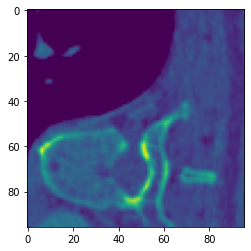

In [17]:
import matplotlib.pyplot as plt

sample_train = train_dataset[16]
plt.imshow(sample_train[0][2][PATCH_SIZE//2])

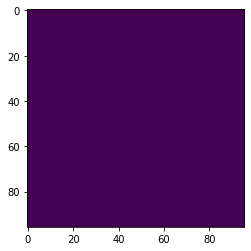

In [18]:
plt.imshow(sample_train[1][PATCH_SIZE//2])

# Dataloader 

In [19]:
import multiprocessing
multiprocessing.cpu_count()

48

In [20]:
from torch.utils.data import DataLoader

USE_CUDA = torch.cuda.is_available()
DEVICE = torch.device("cuda" if USE_CUDA else "cpu")
# NUM_WORKERS = multiprocessing.cpu_count()
NUM_WORKERS = 8

def initTrainDl(train_ds, batch_size = BATCH_SIZE):
    if USE_CUDA:
        batch_size *= torch.cuda.device_count()

    train_dl = DataLoader(
        train_ds,
        batch_size=batch_size,
        num_workers=NUM_WORKERS,
        pin_memory=USE_CUDA,
        shuffle=True,
        drop_last=False # to prevent gradient exploding
    )
    return train_dl

def initValDl(val_ds, batch_size = BATCH_SIZE):
    val_dl = DataLoader(
        val_ds,
        batch_size=batch_size,
        num_workers=NUM_WORKERS,
        pin_memory=USE_CUDA,
    )
    return val_dl

# Set for training

In [21]:
import logging
log = logging.getLogger("3DUnet")
# log.setLevel(logging.WARN)
# log.setLevel(logging.INFO)
log.setLevel(logging.DEBUG)

In [22]:
import datetime
# For logging 
trn_writer = None
val_writer = None
# TB_PREFIX = img_type + "_fn0"
time_str = datetime.datetime.now().strftime('%Y-%m-%d_%H.%M.%S')

In [23]:
# Used for computeClassificationLoss and logMetrics to index into metrics_t/metrics_a
# METRICS_LABEL_NDX = 0
METRICS_LOSS_NDX = 1
# METRICS_FN_LOSS_NDX = 2
# METRICS_ALL_LOSS_NDX = 3

# METRICS_PTP_NDX = 4
# METRICS_PFN_NDX = 5
# METRICS_MFP_NDX = 6
METRICS_TP_NDX = 7
METRICS_FN_NDX = 8
METRICS_FP_NDX = 9

METRICS_SIZE = 10

In [24]:
from torch.optim import SGD, AdamW, RMSprop
from torch import nn
from pytorch3dunet.unet3d.model import UNet3D, ResidualUNet3D

class SigmoidWrapper(nn.Module):
  def __init__(self, net):
    super().__init__()
    self.net = net
      
  def forward(self, imgs):
    logits = self.net(imgs)
    output = torch.sigmoid(logits)
    return output


def initModel():    
#     segmentation_model = ResidualUNet3D(in_channels=3, out_channels=1, num_groups=32, f_maps=32, final_sigmoid=True, testing=True, num_levels=6)
    unetr = UNETR(in_channels=3, out_channels=1, img_size = PATCH_SIZE, dropout_rate=DROPOUT)
    segmentation_model = SigmoidWrapper(unetr)
    # augmentation_model = SegmentationAugmentation(**self.augmentation_dict)

    if USE_CUDA:
        log.info("Using CUDA; {} devices.".format(torch.cuda.device_count()))
        if torch.cuda.device_count() > 1:
            segmentation_model = nn.DataParallel(segmentation_model)
            # augmentation_model = nn.DataParallel(augmentation_model)
        segmentation_model = segmentation_model.to(DEVICE)
        # augmentation_model = augmentation_model.to(DEVICE)

    return segmentation_model #, augmentation_model

def initOptimizer():
    return AdamW(segmentation_model.parameters(), lr=1e-4, weight_decay=1e-5)
    # return SGD(segmentation_model.parameters(), lr=0.001, momentum=0.99)

segmentation_model = initModel()
optimizer = initOptimizer()

# Load model
if MODEL_TO_LOAD :
  model_folder = os.path.join(BASE_DIR, 'models')
  model_path = os.path.join(model_folder, MODEL_TO_LOAD)
  seg_dict = torch.load(model_path, map_location='cpu')
  if torch.cuda.device_count() > 1:
    segmentation_model.module.load_state_dict(seg_dict['model_state'])
  else:
    segmentation_model.load_state_dict(seg_dict['model_state'])
    

In [25]:
segmentation_model

DataParallel(
  (module): SigmoidWrapper(
    (net): UNETR(
      (vit): ViT(
        (patch_embedding): PatchEmbeddingBlock(
          (patch_embeddings): Conv3d(3, 768, kernel_size=(16, 16, 16), stride=(16, 16, 16))
          (dropout): Dropout(p=0, inplace=False)
        )
        (blocks): ModuleList(
          (0): TransformerBlock(
            (mlp): MLPBlock(
              (linear1): Linear(in_features=768, out_features=3072, bias=True)
              (linear2): Linear(in_features=3072, out_features=768, bias=True)
              (fn): GELU()
              (drop1): Dropout(p=0, inplace=False)
              (drop2): Dropout(p=0, inplace=False)
            )
            (norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
            (attn): SABlock(
              (out_proj): Linear(in_features=768, out_features=768, bias=True)
              (qkv): Linear(in_features=768, out_features=2304, bias=False)
              (drop_output): Dropout(p=0, inplace=False)
              

In [26]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
count_parameters(segmentation_model)

99083089

In [27]:
from util.util import enumerateWithEstimate

def doTraining(epoch_ndx, train_dl):
    trnMetrics_g = torch.zeros(METRICS_SIZE, len(train_dl.dataset), device=DEVICE)
    segmentation_model.train()
    # train_dl.dataset.shuffleSamples() - 정의에서 처리했음

    batch_iter = enumerateWithEstimate(
        train_dl,
        "E{} Training".format(epoch_ndx),
        start_ndx=train_dl.num_workers,
    )
    for batch_ndx, batch_tup in batch_iter:
        optimizer.zero_grad()

        loss_var = computeBatchLoss(batch_ndx, batch_tup, train_dl.batch_size, trnMetrics_g)
        loss_var.backward()
        
        # Gradient clipping 
        max_norm = 5
        torch.nn.utils.clip_grad_norm_(segmentation_model.parameters(), max_norm)
        optimizer.step()
    global totalTrainingSamples_count
    totalTrainingSamples_count += trnMetrics_g.size(1)

    return trnMetrics_g.to('cpu')

def doValidation(epoch_ndx, val_dl):
    with torch.no_grad():
        valMetrics_g = torch.zeros(METRICS_SIZE, len(val_dl.dataset), device=DEVICE)
        segmentation_model.eval()

        batch_iter = enumerateWithEstimate(
            val_dl,
            "E{} Validation ".format(epoch_ndx),
            start_ndx=val_dl.num_workers,
        )
        for batch_ndx, batch_tup in batch_iter:
            computeBatchLossVal(batch_ndx, batch_tup, val_dl.batch_size, valMetrics_g)

    return valMetrics_g.to('cpu')

def computeBatchLoss(batch_ndx, batch_tup, batch_size, metrics_g,
                      classificationThreshold=0.5):
    input_t, label_t= batch_tup
    
    input_g = input_t.to(DEVICE, non_blocking=True)
    label_g = label_t.to(DEVICE, non_blocking=True)

    # if segmentation_model.training and augmentation_dict:
    #     input_g, label_g = augmentation_model(input_g, label_g)

    prediction_g_multi_ch = segmentation_model(input_g)
    prediction_g = prediction_g_multi_ch[:,0] # B, C, D, H, W -> B, D, H, W
    diceLoss_g = diceLoss(prediction_g, label_g)
#     fnLoss_g = diceLoss(prediction_g * label_g, label_g)
    ceLoss = nn.BCELoss()
    ceLoss_g = ceLoss(prediction_g, label_g.float())
    start_ndx = batch_ndx * batch_size
    end_ndx = start_ndx + input_t.size(0)

    with torch.no_grad():
        predictionBool_g = (prediction_g > classificationThreshold).to(torch.float32)

        tp = (     predictionBool_g *  label_g).sum(dim=[1,2,3])
        fn = ((1 - predictionBool_g) *  label_g).sum(dim=[1,2,3])
        fp = (     predictionBool_g * (~label_g)).sum(dim=[1,2,3])

        metrics_g[METRICS_LOSS_NDX, start_ndx:end_ndx] = diceLoss_g
        metrics_g[METRICS_TP_NDX, start_ndx:end_ndx] = tp
        metrics_g[METRICS_FN_NDX, start_ndx:end_ndx] = fn
        metrics_g[METRICS_FP_NDX, start_ndx:end_ndx] = fp

    return diceLoss_g.mean() + ceLoss_g # + fnLoss_g.mean() * FN_LOSS 

def computeBatchLossVal(batch_ndx, batch_tup, batch_size, metrics_g,
                      classificationThreshold=0.5):
    input_t, label_t= batch_tup
    
    input_g = input_t.to(DEVICE, non_blocking=True)
    label_g = label_t.to(DEVICE, non_blocking=True)

    prediction_g_multi_ch = sliding_window_inference(input_g, (PATCH_SIZE, PATCH_SIZE, PATCH_SIZE), BATCH_SIZE, segmentation_model)
    prediction_g = prediction_g_multi_ch[:,0] # B, C, D, H, W -> B, D, H, W
    diceLoss_g = diceLoss(prediction_g, label_g)
    fnLoss_g = diceLoss(prediction_g * label_g, label_g)
    start_ndx = batch_ndx * batch_size
    end_ndx = start_ndx + input_t.size(0)

    with torch.no_grad():
        predictionBool_g = (prediction_g > classificationThreshold).to(torch.float32)

        tp = (     predictionBool_g *  label_g).sum(dim=[1,2,3])
        fn = ((1 - predictionBool_g) *  label_g).sum(dim=[1,2,3])
        fp = (     predictionBool_g * (~label_g)).sum(dim=[1,2,3])

        metrics_g[METRICS_LOSS_NDX, start_ndx:end_ndx] = diceLoss_g
        metrics_g[METRICS_TP_NDX, start_ndx:end_ndx] = tp
        metrics_g[METRICS_FN_NDX, start_ndx:end_ndx] = fn
        metrics_g[METRICS_FP_NDX, start_ndx:end_ndx] = fp

    return diceLoss_g.mean() + fnLoss_g.mean() * FN_LOSS

def diceLoss(prediction_g, label_g, epsilon=1):
    diceLabel_g = label_g.sum(dim=[1,2,3])
    dicePrediction_g = prediction_g.sum(dim=[1,2,3])
    diceCorrect_g = (prediction_g * label_g).sum(dim=[1,2,3])

    diceRatio_g = (2 * diceCorrect_g + epsilon) \
        / (dicePrediction_g + diceLabel_g + epsilon)

    return 1 - diceRatio_g

In [28]:
from torch.utils.tensorboard import SummaryWriter

def logMetrics(epoch_ndx, mode_str, metrics_t, tb_type = TB_PREFIX):
    log.info("E{} {} {}".format(
        epoch_ndx,
        "Unet",
        tb_type
    ))

    metrics_a = metrics_t.detach().numpy()
    sum_a = metrics_a.sum(axis=1)
    assert np.isfinite(metrics_a).all()

    allLabel_count = sum_a[METRICS_TP_NDX] + sum_a[METRICS_FN_NDX]

    metrics_dict = {}
    metrics_dict['loss/all'] = metrics_a[METRICS_LOSS_NDX].mean()

    metrics_dict['percent_all/tp'] = \
        sum_a[METRICS_TP_NDX] / (allLabel_count or 1) * 100 
    metrics_dict['percent_all/fn'] = \
        sum_a[METRICS_FN_NDX] / (allLabel_count or 1) * 100
    metrics_dict['percent_all/fp'] = \
        sum_a[METRICS_FP_NDX] / (allLabel_count or 1) * 100


    precision = metrics_dict['pr/precision'] = sum_a[METRICS_TP_NDX] \
        / ((sum_a[METRICS_TP_NDX] + sum_a[METRICS_FP_NDX]) or 1)
    recall    = metrics_dict['pr/recall']    = sum_a[METRICS_TP_NDX] \
        / ((sum_a[METRICS_TP_NDX] + sum_a[METRICS_FN_NDX]) or 1)

    metrics_dict['pr/f1_score'] = 2 * (precision * recall) \
        / ((precision + recall) or 1)

    log.info(("E{} {:8} "
              + "{loss/all:.4f} loss, "
              + "{pr/precision:.4f} precision, "
              + "{pr/recall:.4f} recall, "
              + "{pr/f1_score:.4f} f1 score"
              ).format(
        epoch_ndx,
        mode_str,
        **metrics_dict,
    ))
    log.info(("E{} {:8} "
              + "{loss/all:.4f} loss, "
              + "{percent_all/tp:-5.1f}% tp, {percent_all/fn:-5.1f}% fn, {percent_all/fp:-9.1f}% fp"
    ).format(
        epoch_ndx,
        mode_str + '_all',
        **metrics_dict,
    ))
    global trn_writer
    global val_writer
    initTensorboardWriters()
    if mode_str == 'trn':
      writer = trn_writer
    elif mode_str == 'pred':
      writer = pred_writer
    else:
      writer = val_writer

    prefix_str = 'seg_'

    global totalTrainingSamples_count
    for key, value in metrics_dict.items():
        writer.add_scalar(prefix_str + key, value, totalTrainingSamples_count)

    writer.flush()

    score = metrics_dict['pr/recall']

    return score

import os

LOG_DIR = os.path.join(BASE_DIR, 'logs')
if not os.path.exists(LOG_DIR):
  os.mkdir(LOG_DIR)
  
def initTensorboardWriters():
    global trn_writer
    global val_writer
#     global pred_writer
    if trn_writer is None:
        trn_writer = SummaryWriter(
            log_dir= os.path.join(LOG_DIR, '{}_trn_seg_{}').format(TB_PREFIX, time_str) )
        val_writer = SummaryWriter(
            log_dir= os.path.join(LOG_DIR, '{}_val_seg_{}').format(TB_PREFIX, time_str) )
#         pred_writer = SummaryWriter(
#             log_dir= os.path.join(LOG_DIR, '{}_pred_seg_{}').format(TB_PREFIX, time_str) )

In [29]:
def saveModel(type_str, epoch_ndx, tb_pre = TB_PREFIX):
    model_name = '{}_model_epoch{}'.format(tb_pre, epoch_ndx)
    file_path = os.path.join(
        BASE_DIR,
        'models',
        model_name
        )

    os.makedirs(os.path.dirname(file_path), mode=0o755, exist_ok=True)

    model = segmentation_model
    if isinstance(model, torch.nn.DataParallel):
        model = model.module

    state = {
        'sys_argv': sys.argv,
        'time': str(datetime.datetime.now()),
        'model_state': model.state_dict(),
        'model_name': type(model).__name__,
        'optimizer_state' : optimizer.state_dict(),
        'optimizer_name': type(optimizer).__name__,
        'epoch': epoch_ndx,
        'totalTrainingSamples_count': totalTrainingSamples_count,
    }
    torch.save(state, file_path)
    log.info(f"Model was saved to {file_path}")
#     remote_location = 's3://{0}'.format(os.path.join(s3bucket, 'result/models', model_name))
#     S3FS.put(file_path, remote_location)
#     log.info("Saved model params to {} and remote S3 bucket".format(file_path))

    with open(file_path, 'rb') as f:
        log.info("SHA1: " + hashlib.sha1(f.read()).hexdigest())

In [30]:
import torch.nn.functional as F

# Pytorch 3D image tensor = Depth, Height, Weight
#w(l-> r), h(t->b), d(u->d) 순서로군

def pad_for_division(image, patch_size):
    patch_d, patch_h, patch_w = patch_size 
    assert patch_d % 32 == 0 & patch_h % 32 == 0 & patch_w % 32 == 0, "Patch size should be divided by 32"
    padding_d = patch_d - image.size(0)%patch_d
    padding_h = patch_h - image.size(1)%patch_h
    padding_w = patch_w - image.size(2)%patch_w
    padded_image = F.pad(image, (0, padding_w, 0, padding_h, 0, padding_d))
    return padded_image 

def pad_for_half(image, patch_size):
    patch_d, patch_h, patch_w = patch_size 
    padded_image = F.pad(image, (patch_w//2, patch_w//2, patch_h//2, patch_h//2, patch_d//2, patch_d//2))
    return padded_image 

    
def adjust_window(image, window):
    width = window[0]
    level = window[1]
    upper = level+width/2
    lower = level-width/2
    copied_image = image.clip(lower, upper)
    copied_image = copied_image-lower
    return (copied_image/(upper-lower))

def convert_to_multi_channel_img(image, windows):
    adjusted_images = [adjust_window(image, window) for window in windows]
    return torch.stack(adjusted_images)

# Process : padding -> adjust windows -> unfold -> neural network -> fold -> crop
#           another padding -> adjust windows -> unfold -> neural network -> fold -> crop 
#           average all by 2 -> compare with the label. 
# 원래는 8개로 해야되는데, 간이 버전이라고 생각해볼 수 있겠음. 

def pred_image_with_model(padded_image, model, batch_size, patch_size):
    '''
    padded_image : image tensor with size of [D, H, W]
    patch_size : tuple with size of 3
    return pred_label : tensor with size of [D, H, W]
    '''
    windows = [(500,200), (700,400), (1200,400)]
    input_channel = padded_image.size(0)
    output_channel = 1
    patch_d, patch_h, patch_w = patch_size 
    total_batch_size = batch_size * torch.cuda.device_count()

    patches = padded_image.unfold(0, patch_d, patch_d).unfold(1, patch_h, patch_h).unfold(2, patch_w, patch_w)
    unfold_shape = patches.size()
    patches = patches.reshape(-1, patch_d, patch_h, patch_w)
    
    processed_patches = torch.zeros_like(patches)
    iter_num = int(np.ceil(patches.size(0)/total_batch_size))
    for i in range(iter_num):
        start = i * total_batch_size
        end = (i+1) * total_batch_size
        batch = patches[start:end]
        batch = convert_to_multi_channel_img(batch, windows)
        batch = batch.permute(1,0,2,3,4)
        proccessed_batch = model(batch).squeeze(1)
        processed_patches[start:end] = proccessed_batch
    
    pred_patches = processed_patches.view(unfold_shape)
    output_d = unfold_shape[0] * unfold_shape[3]
    output_h = unfold_shape[1] * unfold_shape[4]
    output_w = unfold_shape[2] * unfold_shape[5]
    pred_patches = pred_patches.permute(0, 3, 1, 4, 2, 5)
    pred_label = pred_patches.reshape(output_d, output_h, output_w)
    return pred_label

def predict_one_case(image_t, batch_size ,patch_size):
    pad_image = pad_for_division(image_t, patch_size)
    half_pad_image = pad_for_half(pad_image, patch_size)
    d,h,w = image_t.shape
    half_pad_d, half_pad_h, half_pad_w = [size//2 for size in patch_size]
    
    with torch.no_grad():
        segmentation_model.eval()
        pred_label = pred_image_with_model(pad_image, segmentation_model, batch_size, patch_size)
        pred_half_pad_label = pred_image_with_model(half_pad_image, segmentation_model, batch_size, patch_size)
        
    cropped_pred = pred_label[:d, :h, :w]
    cropped_pred_2 = pred_half_pad_label[half_pad_d:half_pad_d+d, half_pad_h:half_pad_h+h, half_pad_w:half_pad_w+w]
    mean_pred = (cropped_pred + cropped_pred_2) / 2
    return mean_pred


def doPrediction(epoch_ndx, files, batch_size, patch_size):
    log.info("E{} Prediction {}".format(epoch_ndx, TB_PREFIX))
    predMetrics_g = torch.zeros(METRICS_SIZE, len(files), device=DEVICE)
    segmentation_model.eval()
    
    for i, file in enumerate(files):
        image = np.load(get_img_path(file))
        image_t = torch.tensor(image)
        label = np.load(get_label_path(file))
        
        pred = predict_one_case(image_t, batch_size, patch_size)
        pred_t = pred > 0.5 # classificationThreshold = 0.5
        label_t = torch.tensor(label)
        
        predictionBool_g = pred_t.unsqueeze(0).to(torch.float32)
        label_g = label_t.unsqueeze(0)
        
        diceLoss_g = diceLoss(predictionBool_g, label_g, epsilon=0.01)
        fnLoss_g = diceLoss(predictionBool_g * label_g, label_g)

        tp = (     predictionBool_g *  label_g).sum(dim=[1,2,3])
        fn = ((1 - predictionBool_g) *  label_g).sum(dim=[1,2,3])
        fp = (     predictionBool_g * (~label_g)).sum(dim=[1,2,3])
        
        predMetrics_g[METRICS_LOSS_NDX, i] = diceLoss_g # 차원 에러날듯 - i로 골라버리면 차원이 하나 줄기 때문.. 확인해봐야함. 
        predMetrics_g[METRICS_TP_NDX, i] = tp
        predMetrics_g[METRICS_FN_NDX, i] = fn
        predMetrics_g[METRICS_FP_NDX, i] = fp
        
    return predMetrics_g.to('cpu')

# Train

In [31]:
log.info("Starting traning...")

train_dl = initTrainDl(train_dataset)
val_dl = initValDl(val_dataset)

best_score = 0.0
validation_cadence = 10
pred_cadence = 20

totalTrainingSamples_count = 0 

2022-05-02 01:57:27,649 INFO     pid:1277747 3DUnet:001:<module> Starting traning...


In [39]:
EPOCHS = 1000

In [41]:
for g in optimizer.param_groups:
    g['lr'] = 0.001
    g['weight_decay'] = 0.0001

In [42]:
for epoch_ndx in range(501, 601):
    log.info("Epoch {} of {}, {}/{} batches of size {}*{}".format(
        epoch_ndx,
        EPOCHS,
        len(train_dl),
        len(val_dl),
        BATCH_SIZE,
        (torch.cuda.device_count() if USE_CUDA else 1),
    ))

    trnMetrics_t = doTraining(epoch_ndx, train_dl)

    logMetrics(epoch_ndx, 'trn', trnMetrics_t)

    if epoch_ndx == 1 or epoch_ndx % validation_cadence == 0:
        # if validation is wanted
        valMetrics_t = doValidation(epoch_ndx, val_dl)
        score = logMetrics(epoch_ndx, 'val', valMetrics_t)
        best_score = max(score, best_score)

        # self.saveModel('seg', epoch_ndx, score == best_score)
        saveModel('seg', epoch_ndx)
        # self.logImages(epoch_ndx, 'trn', train_dl)
        # self.logImages(epoch_ndx, 'val', val_dl)

#     if epoch_ndx % pred_cadence ==0:
#         predMetrics_t = doPrediction(epoch_ndx, VAL_FILES, batch_size=1, patch_size=(128,256,256))
#         score = logMetrics(epoch_ndx, 'pred', predMetrics_t)
        
trn_writer.close()
val_writer.close()

2022-05-02 22:55:19,691 INFO     pid:1277747 3DUnet:008:<module> Epoch 501 of 1000, 94/72 batches of size 8*4
2022-05-02 22:55:19,711 WARNING  pid:1277747 util.util:221:enumerateWithEstimate E501 Training ----/94, starting
2022-05-02 22:55:53,027 INFO     pid:1277747 util.util:241:enumerateWithEstimate E501 Training   16/94, done at 2022-05-02 22:57:30, 0:01:49
2022-05-02 22:56:13,452 INFO     pid:1277747 util.util:241:enumerateWithEstimate E501 Training   32/94, done at 2022-05-02 22:57:31, 0:01:49
2022-05-02 22:56:53,627 INFO     pid:1277747 util.util:241:enumerateWithEstimate E501 Training   64/94, done at 2022-05-02 22:57:30, 0:01:48
2022-05-02 22:57:29,736 WARNING  pid:1277747 util.util:252:enumerateWithEstimate E501 Training ----/94, done at 2022-05-02 22:57:29
2022-05-02 22:57:29,743 INFO     pid:1277747 3DUnet:007:logMetrics E501 Unet bonemeta_dr_0_UNETR_PS96
2022-05-02 22:57:29,745 INFO     pid:1277747 3DUnet:043:logMetrics E501 trn      0.5578 loss, 0.3363 precision, 0.2851 r

2022-05-02 23:11:02,415 INFO     pid:1277747 util.util:241:enumerateWithEstimate E508 Training   16/94, done at 2022-05-02 23:12:39, 0:01:47
2022-05-02 23:11:22,575 INFO     pid:1277747 util.util:241:enumerateWithEstimate E508 Training   32/94, done at 2022-05-02 23:12:39, 0:01:48
2022-05-02 23:12:02,686 INFO     pid:1277747 util.util:241:enumerateWithEstimate E508 Training   64/94, done at 2022-05-02 23:12:39, 0:01:47
2022-05-02 23:12:38,923 WARNING  pid:1277747 util.util:252:enumerateWithEstimate E508 Training ----/94, done at 2022-05-02 23:12:38
2022-05-02 23:12:38,931 INFO     pid:1277747 3DUnet:007:logMetrics E508 Unet bonemeta_dr_0_UNETR_PS96
2022-05-02 23:12:38,933 INFO     pid:1277747 3DUnet:043:logMetrics E508 trn      0.5717 loss, 0.3439 precision, 0.2620 recall, 0.2974 f1 score
2022-05-02 23:12:38,934 INFO     pid:1277747 3DUnet:051:logMetrics E508 trn_all  0.5717 loss,  26.2% tp,  73.8% fn,      50.0% fp
2022-05-02 23:12:38,939 INFO     pid:1277747 3DUnet:008:<module> Epoch

2022-05-02 23:24:30,451 INFO     pid:1277747 util.util:241:enumerateWithEstimate E514 Training   16/94, done at 2022-05-02 23:26:12, 0:01:54
2022-05-02 23:24:50,513 INFO     pid:1277747 util.util:241:enumerateWithEstimate E514 Training   32/94, done at 2022-05-02 23:26:08, 0:01:50
2022-05-02 23:25:30,738 INFO     pid:1277747 util.util:241:enumerateWithEstimate E514 Training   64/94, done at 2022-05-02 23:26:07, 0:01:48
2022-05-02 23:26:06,913 WARNING  pid:1277747 util.util:252:enumerateWithEstimate E514 Training ----/94, done at 2022-05-02 23:26:06
2022-05-02 23:26:06,920 INFO     pid:1277747 3DUnet:007:logMetrics E514 Unet bonemeta_dr_0_UNETR_PS96
2022-05-02 23:26:06,923 INFO     pid:1277747 3DUnet:043:logMetrics E514 trn      0.5658 loss, 0.3421 precision, 0.2611 recall, 0.2961 f1 score
2022-05-02 23:26:06,924 INFO     pid:1277747 3DUnet:051:logMetrics E514 trn_all  0.5658 loss,  26.1% tp,  73.9% fn,      50.2% fp
2022-05-02 23:26:06,929 INFO     pid:1277747 3DUnet:008:<module> Epoch

2022-05-02 23:39:28,125 INFO     pid:1277747 util.util:241:enumerateWithEstimate E520 Validation    64/72, done at 2022-05-02 23:39:30, 0:00:19
2022-05-02 23:39:30,409 WARNING  pid:1277747 util.util:252:enumerateWithEstimate E520 Validation  ----/72, done at 2022-05-02 23:39:30
2022-05-02 23:39:30,411 INFO     pid:1277747 3DUnet:007:logMetrics E520 Unet bonemeta_dr_0_UNETR_PS96
2022-05-02 23:39:30,412 INFO     pid:1277747 3DUnet:043:logMetrics E520 val      0.5530 loss, 0.5689 precision, 0.1862 recall, 0.2805 f1 score
2022-05-02 23:39:30,414 INFO     pid:1277747 3DUnet:051:logMetrics E520 val_all  0.5530 loss,  18.6% tp,  81.4% fn,      14.1% fp
2022-05-02 23:39:32,306 INFO     pid:1277747 3DUnet:026:saveModel Model was saved to /workspace/BoneMeta_all_1mm/models/bonemeta_dr_0_UNETR_PS96_model_epoch520
2022-05-02 23:39:34,334 INFO     pid:1277747 3DUnet:032:saveModel SHA1: 118c578e1888193db20e6dc5ea33dbf29c6e07ac
2022-05-02 23:39:34,335 INFO     pid:1277747 3DUnet:008:<module> Epoch 52

2022-05-02 23:53:31,035 INFO     pid:1277747 util.util:241:enumerateWithEstimate E527 Training   32/94, done at 2022-05-02 23:54:49, 0:01:49
2022-05-02 23:54:11,211 INFO     pid:1277747 util.util:241:enumerateWithEstimate E527 Training   64/94, done at 2022-05-02 23:54:47, 0:01:48
2022-05-02 23:54:47,291 WARNING  pid:1277747 util.util:252:enumerateWithEstimate E527 Training ----/94, done at 2022-05-02 23:54:47
2022-05-02 23:54:47,299 INFO     pid:1277747 3DUnet:007:logMetrics E527 Unet bonemeta_dr_0_UNETR_PS96
2022-05-02 23:54:47,301 INFO     pid:1277747 3DUnet:043:logMetrics E527 trn      0.5775 loss, 0.3507 precision, 0.2810 recall, 0.3120 f1 score
2022-05-02 23:54:47,302 INFO     pid:1277747 3DUnet:051:logMetrics E527 trn_all  0.5775 loss,  28.1% tp,  71.9% fn,      52.0% fp
2022-05-02 23:54:47,306 INFO     pid:1277747 3DUnet:008:<module> Epoch 528 of 1000, 94/72 batches of size 8*4
2022-05-02 23:54:47,312 WARNING  pid:1277747 util.util:221:enumerateWithEstimate E528 Training ----/9

2022-05-03 00:07:00,469 INFO     pid:1277747 util.util:241:enumerateWithEstimate E533 Training   32/94, done at 2022-05-03 00:08:18, 0:01:50
2022-05-03 00:07:40,530 INFO     pid:1277747 util.util:241:enumerateWithEstimate E533 Training   64/94, done at 2022-05-03 00:08:17, 0:01:48
2022-05-03 00:08:16,697 WARNING  pid:1277747 util.util:252:enumerateWithEstimate E533 Training ----/94, done at 2022-05-03 00:08:16
2022-05-03 00:08:16,704 INFO     pid:1277747 3DUnet:007:logMetrics E533 Unet bonemeta_dr_0_UNETR_PS96
2022-05-03 00:08:16,706 INFO     pid:1277747 3DUnet:043:logMetrics E533 trn      0.5580 loss, 0.3430 precision, 0.2724 recall, 0.3036 f1 score
2022-05-03 00:08:16,707 INFO     pid:1277747 3DUnet:051:logMetrics E533 trn_all  0.5580 loss,  27.2% tp,  72.8% fn,      52.2% fp
2022-05-03 00:08:16,712 INFO     pid:1277747 3DUnet:008:<module> Epoch 534 of 1000, 94/72 batches of size 8*4
2022-05-03 00:08:16,717 WARNING  pid:1277747 util.util:221:enumerateWithEstimate E534 Training ----/9

2022-05-03 00:22:56,270 INFO     pid:1277747 util.util:241:enumerateWithEstimate E540 Training   64/94, done at 2022-05-03 00:23:32, 0:01:48
2022-05-03 00:23:32,460 WARNING  pid:1277747 util.util:252:enumerateWithEstimate E540 Training ----/94, done at 2022-05-03 00:23:32
2022-05-03 00:23:32,466 INFO     pid:1277747 3DUnet:007:logMetrics E540 Unet bonemeta_dr_0_UNETR_PS96
2022-05-03 00:23:32,469 INFO     pid:1277747 3DUnet:043:logMetrics E540 trn      0.5476 loss, 0.3443 precision, 0.2873 recall, 0.3132 f1 score
2022-05-03 00:23:32,470 INFO     pid:1277747 3DUnet:051:logMetrics E540 trn_all  0.5476 loss,  28.7% tp,  71.3% fn,      54.7% fp
2022-05-03 00:23:32,478 WARNING  pid:1277747 util.util:221:enumerateWithEstimate E540 Validation  ----/72, starting
2022-05-03 00:23:41,665 INFO     pid:1277747 util.util:241:enumerateWithEstimate E540 Validation    16/72, done at 2022-05-03 00:23:57, 0:00:18
2022-05-03 00:23:46,387 INFO     pid:1277747 util.util:241:enumerateWithEstimate E540 Valida

2022-05-03 00:36:31,827 INFO     pid:1277747 util.util:241:enumerateWithEstimate E546 Training   64/94, done at 2022-05-03 00:37:08, 0:01:49
2022-05-03 00:37:08,043 WARNING  pid:1277747 util.util:252:enumerateWithEstimate E546 Training ----/94, done at 2022-05-03 00:37:08
2022-05-03 00:37:08,049 INFO     pid:1277747 3DUnet:007:logMetrics E546 Unet bonemeta_dr_0_UNETR_PS96
2022-05-03 00:37:08,051 INFO     pid:1277747 3DUnet:043:logMetrics E546 trn      0.5594 loss, 0.3453 precision, 0.2777 recall, 0.3078 f1 score
2022-05-03 00:37:08,052 INFO     pid:1277747 3DUnet:051:logMetrics E546 trn_all  0.5594 loss,  27.8% tp,  72.2% fn,      52.6% fp
2022-05-03 00:37:08,056 INFO     pid:1277747 3DUnet:008:<module> Epoch 547 of 1000, 94/72 batches of size 8*4
2022-05-03 00:37:08,061 WARNING  pid:1277747 util.util:221:enumerateWithEstimate E547 Training ----/94, starting
2022-05-03 00:37:41,845 INFO     pid:1277747 util.util:241:enumerateWithEstimate E547 Training   16/94, done at 2022-05-03 00:39:

2022-05-03 00:50:02,396 INFO     pid:1277747 util.util:241:enumerateWithEstimate E552 Training   64/94, done at 2022-05-03 00:50:38, 0:01:48
2022-05-03 00:50:38,534 WARNING  pid:1277747 util.util:252:enumerateWithEstimate E552 Training ----/94, done at 2022-05-03 00:50:38
2022-05-03 00:50:38,541 INFO     pid:1277747 3DUnet:007:logMetrics E552 Unet bonemeta_dr_0_UNETR_PS96
2022-05-03 00:50:38,543 INFO     pid:1277747 3DUnet:043:logMetrics E552 trn      0.5670 loss, 0.3393 precision, 0.2854 recall, 0.3100 f1 score
2022-05-03 00:50:38,544 INFO     pid:1277747 3DUnet:051:logMetrics E552 trn_all  0.5670 loss,  28.5% tp,  71.5% fn,      55.6% fp
2022-05-03 00:50:38,549 INFO     pid:1277747 3DUnet:008:<module> Epoch 553 of 1000, 94/72 batches of size 8*4
2022-05-03 00:50:38,554 WARNING  pid:1277747 util.util:221:enumerateWithEstimate E553 Training ----/94, starting
2022-05-03 00:51:10,443 INFO     pid:1277747 util.util:241:enumerateWithEstimate E553 Training   16/94, done at 2022-05-03 00:52:

2022-05-03 01:05:45,030 WARNING  pid:1277747 util.util:252:enumerateWithEstimate E559 Training ----/94, done at 2022-05-03 01:05:45
2022-05-03 01:05:45,036 INFO     pid:1277747 3DUnet:007:logMetrics E559 Unet bonemeta_dr_0_UNETR_PS96
2022-05-03 01:05:45,039 INFO     pid:1277747 3DUnet:043:logMetrics E559 trn      0.5570 loss, 0.3496 precision, 0.2844 recall, 0.3136 f1 score
2022-05-03 01:05:45,040 INFO     pid:1277747 3DUnet:051:logMetrics E559 trn_all  0.5570 loss,  28.4% tp,  71.6% fn,      52.9% fp
2022-05-03 01:05:45,044 INFO     pid:1277747 3DUnet:008:<module> Epoch 560 of 1000, 94/72 batches of size 8*4
2022-05-03 01:05:45,050 WARNING  pid:1277747 util.util:221:enumerateWithEstimate E560 Training ----/94, starting
2022-05-03 01:06:17,606 INFO     pid:1277747 util.util:241:enumerateWithEstimate E560 Training   16/94, done at 2022-05-03 01:07:54, 0:01:47
2022-05-03 01:06:37,746 INFO     pid:1277747 util.util:241:enumerateWithEstimate E560 Training   32/94, done at 2022-05-03 01:07:

2022-05-03 01:19:13,877 WARNING  pid:1277747 util.util:252:enumerateWithEstimate E565 Training ----/94, done at 2022-05-03 01:19:13
2022-05-03 01:19:13,884 INFO     pid:1277747 3DUnet:007:logMetrics E565 Unet bonemeta_dr_0_UNETR_PS96
2022-05-03 01:19:13,886 INFO     pid:1277747 3DUnet:043:logMetrics E565 trn      0.5542 loss, 0.3415 precision, 0.2719 recall, 0.3028 f1 score
2022-05-03 01:19:13,887 INFO     pid:1277747 3DUnet:051:logMetrics E565 trn_all  0.5542 loss,  27.2% tp,  72.8% fn,      52.4% fp
2022-05-03 01:19:13,891 INFO     pid:1277747 3DUnet:008:<module> Epoch 566 of 1000, 94/72 batches of size 8*4
2022-05-03 01:19:13,896 WARNING  pid:1277747 util.util:221:enumerateWithEstimate E566 Training ----/94, starting
2022-05-03 01:19:45,780 INFO     pid:1277747 util.util:241:enumerateWithEstimate E566 Training   16/94, done at 2022-05-03 01:21:22, 0:01:47
2022-05-03 01:20:06,004 INFO     pid:1277747 util.util:241:enumerateWithEstimate E566 Training   32/94, done at 2022-05-03 01:21:

2022-05-03 01:32:44,637 WARNING  pid:1277747 util.util:252:enumerateWithEstimate E571 Training ----/94, done at 2022-05-03 01:32:44
2022-05-03 01:32:44,642 INFO     pid:1277747 3DUnet:007:logMetrics E571 Unet bonemeta_dr_0_UNETR_PS96
2022-05-03 01:32:44,643 INFO     pid:1277747 3DUnet:043:logMetrics E571 trn      0.5515 loss, 0.3578 precision, 0.2840 recall, 0.3167 f1 score
2022-05-03 01:32:44,644 INFO     pid:1277747 3DUnet:051:logMetrics E571 trn_all  0.5515 loss,  28.4% tp,  71.6% fn,      51.0% fp
2022-05-03 01:32:44,647 INFO     pid:1277747 3DUnet:008:<module> Epoch 572 of 1000, 94/72 batches of size 8*4
2022-05-03 01:32:44,652 WARNING  pid:1277747 util.util:221:enumerateWithEstimate E572 Training ----/94, starting
2022-05-03 01:33:17,268 INFO     pid:1277747 util.util:241:enumerateWithEstimate E572 Training   16/94, done at 2022-05-03 01:34:55, 0:01:49
2022-05-03 01:33:37,458 INFO     pid:1277747 util.util:241:enumerateWithEstimate E572 Training   32/94, done at 2022-05-03 01:34:

2022-05-03 01:47:57,588 INFO     pid:1277747 3DUnet:007:logMetrics E578 Unet bonemeta_dr_0_UNETR_PS96
2022-05-03 01:47:57,590 INFO     pid:1277747 3DUnet:043:logMetrics E578 trn      0.5712 loss, 0.3337 precision, 0.2699 recall, 0.2984 f1 score
2022-05-03 01:47:57,591 INFO     pid:1277747 3DUnet:051:logMetrics E578 trn_all  0.5712 loss,  27.0% tp,  73.0% fn,      53.9% fp
2022-05-03 01:47:57,595 INFO     pid:1277747 3DUnet:008:<module> Epoch 579 of 1000, 94/72 batches of size 8*4
2022-05-03 01:47:57,600 WARNING  pid:1277747 util.util:221:enumerateWithEstimate E579 Training ----/94, starting
2022-05-03 01:48:30,451 INFO     pid:1277747 util.util:241:enumerateWithEstimate E579 Training   16/94, done at 2022-05-03 01:50:07, 0:01:48
2022-05-03 01:48:50,534 INFO     pid:1277747 util.util:241:enumerateWithEstimate E579 Training   32/94, done at 2022-05-03 01:50:07, 0:01:48
2022-05-03 01:49:30,816 INFO     pid:1277747 util.util:241:enumerateWithEstimate E579 Training   64/94, done at 2022-05-

2022-05-03 02:01:28,195 INFO     pid:1277747 3DUnet:007:logMetrics E584 Unet bonemeta_dr_0_UNETR_PS96
2022-05-03 02:01:28,197 INFO     pid:1277747 3DUnet:043:logMetrics E584 trn      0.5627 loss, 0.3398 precision, 0.2769 recall, 0.3051 f1 score
2022-05-03 02:01:28,198 INFO     pid:1277747 3DUnet:051:logMetrics E584 trn_all  0.5627 loss,  27.7% tp,  72.3% fn,      53.8% fp
2022-05-03 02:01:28,202 INFO     pid:1277747 3DUnet:008:<module> Epoch 585 of 1000, 94/72 batches of size 8*4
2022-05-03 02:01:28,208 WARNING  pid:1277747 util.util:221:enumerateWithEstimate E585 Training ----/94, starting
2022-05-03 02:02:01,657 INFO     pid:1277747 util.util:241:enumerateWithEstimate E585 Training   16/94, done at 2022-05-03 02:03:45, 0:01:55
2022-05-03 02:02:21,953 INFO     pid:1277747 util.util:241:enumerateWithEstimate E585 Training   32/94, done at 2022-05-03 02:03:41, 0:01:51
2022-05-03 02:03:03,305 INFO     pid:1277747 util.util:241:enumerateWithEstimate E585 Training   64/94, done at 2022-05-

2022-05-03 02:14:54,753 INFO     pid:1277747 3DUnet:051:logMetrics E590 val_all  0.5060 loss,  28.9% tp,  71.1% fn,      36.7% fp
2022-05-03 02:14:56,636 INFO     pid:1277747 3DUnet:026:saveModel Model was saved to /workspace/BoneMeta_all_1mm/models/bonemeta_dr_0_UNETR_PS96_model_epoch590
2022-05-03 02:14:58,680 INFO     pid:1277747 3DUnet:032:saveModel SHA1: 88d531e0dff75dd2ee1adeb12c26942115f22233
2022-05-03 02:14:58,682 INFO     pid:1277747 3DUnet:008:<module> Epoch 591 of 1000, 94/72 batches of size 8*4
2022-05-03 02:14:58,685 WARNING  pid:1277747 util.util:221:enumerateWithEstimate E591 Training ----/94, starting
2022-05-03 02:15:32,851 INFO     pid:1277747 util.util:241:enumerateWithEstimate E591 Training   16/94, done at 2022-05-03 02:17:10, 0:01:48
2022-05-03 02:15:53,019 INFO     pid:1277747 util.util:241:enumerateWithEstimate E591 Training   32/94, done at 2022-05-03 02:17:10, 0:01:48
2022-05-03 02:16:35,221 INFO     pid:1277747 util.util:241:enumerateWithEstimate E591 Traini

2022-05-03 02:30:09,286 INFO     pid:1277747 3DUnet:043:logMetrics E597 trn      0.5551 loss, 0.3492 precision, 0.2926 recall, 0.3184 f1 score
2022-05-03 02:30:09,287 INFO     pid:1277747 3DUnet:051:logMetrics E597 trn_all  0.5551 loss,  29.3% tp,  70.7% fn,      54.5% fp
2022-05-03 02:30:09,291 INFO     pid:1277747 3DUnet:008:<module> Epoch 598 of 1000, 94/72 batches of size 8*4
2022-05-03 02:30:09,296 WARNING  pid:1277747 util.util:221:enumerateWithEstimate E598 Training ----/94, starting
2022-05-03 02:30:43,169 INFO     pid:1277747 util.util:241:enumerateWithEstimate E598 Training   16/94, done at 2022-05-03 02:32:20, 0:01:48
2022-05-03 02:31:03,212 INFO     pid:1277747 util.util:241:enumerateWithEstimate E598 Training   32/94, done at 2022-05-03 02:32:19, 0:01:47
2022-05-03 02:31:44,308 INFO     pid:1277747 util.util:241:enumerateWithEstimate E598 Training   64/94, done at 2022-05-03 02:32:21, 0:01:49
2022-05-03 02:32:23,597 WARNING  pid:1277747 util.util:252:enumerateWithEstimate 

In [43]:
for g in optimizer.param_groups:
    g['lr'] = 0.0001
    g['weight_decay'] = 0.00001

In [44]:
for epoch_ndx in range(601, EPOCHS + 1):
    log.info("Epoch {} of {}, {}/{} batches of size {}*{}".format(
        epoch_ndx,
        EPOCHS,
        len(train_dl),
        len(val_dl),
        BATCH_SIZE,
        (torch.cuda.device_count() if USE_CUDA else 1),
    ))

    trnMetrics_t = doTraining(epoch_ndx, train_dl)

    logMetrics(epoch_ndx, 'trn', trnMetrics_t)

    if epoch_ndx == 1 or epoch_ndx % validation_cadence == 0:
        # if validation is wanted
        valMetrics_t = doValidation(epoch_ndx, val_dl)
        score = logMetrics(epoch_ndx, 'val', valMetrics_t)
        best_score = max(score, best_score)

        # self.saveModel('seg', epoch_ndx, score == best_score)
        saveModel('seg', epoch_ndx)
        # self.logImages(epoch_ndx, 'trn', train_dl)
        # self.logImages(epoch_ndx, 'val', val_dl)

#     if epoch_ndx % pred_cadence ==0:
#         predMetrics_t = doPrediction(epoch_ndx, VAL_FILES, batch_size=1, patch_size=(128,256,256))
#         score = logMetrics(epoch_ndx, 'pred', predMetrics_t)
        
trn_writer.close()
val_writer.close()

2022-05-03 02:37:13,276 INFO     pid:1277747 3DUnet:008:<module> Epoch 601 of 1000, 94/72 batches of size 8*4
2022-05-03 02:37:13,279 WARNING  pid:1277747 util.util:221:enumerateWithEstimate E601 Training ----/94, starting
2022-05-03 02:37:48,455 INFO     pid:1277747 util.util:241:enumerateWithEstimate E601 Training   16/94, done at 2022-05-03 02:39:29, 0:01:52
2022-05-03 02:38:08,733 INFO     pid:1277747 util.util:241:enumerateWithEstimate E601 Training   32/94, done at 2022-05-03 02:39:26, 0:01:50
2022-05-03 02:38:51,096 INFO     pid:1277747 util.util:241:enumerateWithEstimate E601 Training   64/94, done at 2022-05-03 02:39:28, 0:01:52
2022-05-03 02:39:28,350 WARNING  pid:1277747 util.util:252:enumerateWithEstimate E601 Training ----/94, done at 2022-05-03 02:39:28
2022-05-03 02:39:28,356 INFO     pid:1277747 3DUnet:007:logMetrics E601 Unet bonemeta_dr_0_UNETR_PS96
2022-05-03 02:39:28,358 INFO     pid:1277747 3DUnet:043:logMetrics E601 trn      0.5518 loss, 0.3628 precision, 0.2900 r

2022-05-03 02:53:01,330 INFO     pid:1277747 util.util:241:enumerateWithEstimate E608 Training   16/94, done at 2022-05-03 02:54:38, 0:01:48
2022-05-03 02:53:21,484 INFO     pid:1277747 util.util:241:enumerateWithEstimate E608 Training   32/94, done at 2022-05-03 02:54:38, 0:01:48
2022-05-03 02:54:01,747 INFO     pid:1277747 util.util:241:enumerateWithEstimate E608 Training   64/94, done at 2022-05-03 02:54:38, 0:01:48
2022-05-03 02:54:37,924 WARNING  pid:1277747 util.util:252:enumerateWithEstimate E608 Training ----/94, done at 2022-05-03 02:54:37
2022-05-03 02:54:37,931 INFO     pid:1277747 3DUnet:007:logMetrics E608 Unet bonemeta_dr_0_UNETR_PS96
2022-05-03 02:54:37,934 INFO     pid:1277747 3DUnet:043:logMetrics E608 trn      0.5384 loss, 0.3870 precision, 0.3119 recall, 0.3454 f1 score
2022-05-03 02:54:37,935 INFO     pid:1277747 3DUnet:051:logMetrics E608 trn_all  0.5384 loss,  31.2% tp,  68.8% fn,      49.4% fp
2022-05-03 02:54:37,939 INFO     pid:1277747 3DUnet:008:<module> Epoch

2022-05-03 03:06:39,759 INFO     pid:1277747 util.util:241:enumerateWithEstimate E614 Training   16/94, done at 2022-05-03 03:08:20, 0:01:52
2022-05-03 03:07:00,808 INFO     pid:1277747 util.util:241:enumerateWithEstimate E614 Training   32/94, done at 2022-05-03 03:08:21, 0:01:53
2022-05-03 03:07:41,334 INFO     pid:1277747 util.util:241:enumerateWithEstimate E614 Training   64/94, done at 2022-05-03 03:08:18, 0:01:50
2022-05-03 03:08:17,436 WARNING  pid:1277747 util.util:252:enumerateWithEstimate E614 Training ----/94, done at 2022-05-03 03:08:17
2022-05-03 03:08:17,443 INFO     pid:1277747 3DUnet:007:logMetrics E614 Unet bonemeta_dr_0_UNETR_PS96
2022-05-03 03:08:17,445 INFO     pid:1277747 3DUnet:043:logMetrics E614 trn      0.5422 loss, 0.3889 precision, 0.3157 recall, 0.3485 f1 score
2022-05-03 03:08:17,446 INFO     pid:1277747 3DUnet:051:logMetrics E614 trn_all  0.5422 loss,  31.6% tp,  68.4% fn,      49.6% fp
2022-05-03 03:08:17,451 INFO     pid:1277747 3DUnet:008:<module> Epoch

2022-05-03 03:21:44,053 INFO     pid:1277747 util.util:241:enumerateWithEstimate E620 Validation    64/72, done at 2022-05-03 03:21:46, 0:00:19
2022-05-03 03:21:46,328 WARNING  pid:1277747 util.util:252:enumerateWithEstimate E620 Validation  ----/72, done at 2022-05-03 03:21:46
2022-05-03 03:21:46,331 INFO     pid:1277747 3DUnet:007:logMetrics E620 Unet bonemeta_dr_0_UNETR_PS96
2022-05-03 03:21:46,333 INFO     pid:1277747 3DUnet:043:logMetrics E620 val      0.5316 loss, 0.4816 precision, 0.2588 recall, 0.3367 f1 score
2022-05-03 03:21:46,334 INFO     pid:1277747 3DUnet:051:logMetrics E620 val_all  0.5316 loss,  25.9% tp,  74.1% fn,      27.9% fp
2022-05-03 03:21:48,306 INFO     pid:1277747 3DUnet:026:saveModel Model was saved to /workspace/BoneMeta_all_1mm/models/bonemeta_dr_0_UNETR_PS96_model_epoch620
2022-05-03 03:21:50,316 INFO     pid:1277747 3DUnet:032:saveModel SHA1: 97e740bfa79979b671836f50ce6042903f416b36
2022-05-03 03:21:50,317 INFO     pid:1277747 3DUnet:008:<module> Epoch 62

2022-05-03 03:35:41,990 INFO     pid:1277747 util.util:241:enumerateWithEstimate E627 Training   32/94, done at 2022-05-03 03:37:02, 0:01:54
2022-05-03 03:36:22,162 INFO     pid:1277747 util.util:241:enumerateWithEstimate E627 Training   64/94, done at 2022-05-03 03:36:59, 0:01:50
2022-05-03 03:36:58,295 WARNING  pid:1277747 util.util:252:enumerateWithEstimate E627 Training ----/94, done at 2022-05-03 03:36:58
2022-05-03 03:36:58,302 INFO     pid:1277747 3DUnet:007:logMetrics E627 Unet bonemeta_dr_0_UNETR_PS96
2022-05-03 03:36:58,304 INFO     pid:1277747 3DUnet:043:logMetrics E627 trn      0.5414 loss, 0.3772 precision, 0.2976 recall, 0.3327 f1 score
2022-05-03 03:36:58,305 INFO     pid:1277747 3DUnet:051:logMetrics E627 trn_all  0.5414 loss,  29.8% tp,  70.2% fn,      49.1% fp
2022-05-03 03:36:58,309 INFO     pid:1277747 3DUnet:008:<module> Epoch 628 of 1000, 94/72 batches of size 8*4
2022-05-03 03:36:58,315 WARNING  pid:1277747 util.util:221:enumerateWithEstimate E628 Training ----/9

2022-05-03 03:49:14,032 INFO     pid:1277747 util.util:241:enumerateWithEstimate E633 Training   32/94, done at 2022-05-03 03:50:30, 0:01:48
2022-05-03 03:49:54,446 INFO     pid:1277747 util.util:241:enumerateWithEstimate E633 Training   64/94, done at 2022-05-03 03:50:31, 0:01:48
2022-05-03 03:50:30,820 WARNING  pid:1277747 util.util:252:enumerateWithEstimate E633 Training ----/94, done at 2022-05-03 03:50:30
2022-05-03 03:50:30,826 INFO     pid:1277747 3DUnet:007:logMetrics E633 Unet bonemeta_dr_0_UNETR_PS96
2022-05-03 03:50:30,828 INFO     pid:1277747 3DUnet:043:logMetrics E633 trn      0.5521 loss, 0.3719 precision, 0.3006 recall, 0.3324 f1 score
2022-05-03 03:50:30,830 INFO     pid:1277747 3DUnet:051:logMetrics E633 trn_all  0.5521 loss,  30.1% tp,  69.9% fn,      50.8% fp
2022-05-03 03:50:30,834 INFO     pid:1277747 3DUnet:008:<module> Epoch 634 of 1000, 94/72 batches of size 8*4
2022-05-03 03:50:30,837 WARNING  pid:1277747 util.util:221:enumerateWithEstimate E634 Training ----/9

2022-05-03 04:04:57,563 INFO     pid:1277747 util.util:241:enumerateWithEstimate E640 Training   64/94, done at 2022-05-03 04:05:34, 0:01:49
2022-05-03 04:05:33,691 WARNING  pid:1277747 util.util:252:enumerateWithEstimate E640 Training ----/94, done at 2022-05-03 04:05:33
2022-05-03 04:05:33,698 INFO     pid:1277747 3DUnet:007:logMetrics E640 Unet bonemeta_dr_0_UNETR_PS96
2022-05-03 04:05:33,701 INFO     pid:1277747 3DUnet:043:logMetrics E640 trn      0.5374 loss, 0.3804 precision, 0.3124 recall, 0.3430 f1 score
2022-05-03 04:05:33,702 INFO     pid:1277747 3DUnet:051:logMetrics E640 trn_all  0.5374 loss,  31.2% tp,  68.8% fn,      50.9% fp
2022-05-03 04:05:33,710 WARNING  pid:1277747 util.util:221:enumerateWithEstimate E640 Validation  ----/72, starting
2022-05-03 04:05:43,416 INFO     pid:1277747 util.util:241:enumerateWithEstimate E640 Validation    16/72, done at 2022-05-03 04:05:59, 0:00:19
2022-05-03 04:05:48,294 INFO     pid:1277747 util.util:241:enumerateWithEstimate E640 Valida

2022-05-03 04:18:30,195 INFO     pid:1277747 util.util:241:enumerateWithEstimate E646 Training   64/94, done at 2022-05-03 04:19:06, 0:01:47
2022-05-03 04:19:06,352 WARNING  pid:1277747 util.util:252:enumerateWithEstimate E646 Training ----/94, done at 2022-05-03 04:19:06
2022-05-03 04:19:06,359 INFO     pid:1277747 3DUnet:007:logMetrics E646 Unet bonemeta_dr_0_UNETR_PS96
2022-05-03 04:19:06,361 INFO     pid:1277747 3DUnet:043:logMetrics E646 trn      0.5269 loss, 0.3914 precision, 0.3095 recall, 0.3456 f1 score
2022-05-03 04:19:06,362 INFO     pid:1277747 3DUnet:051:logMetrics E646 trn_all  0.5269 loss,  30.9% tp,  69.1% fn,      48.1% fp
2022-05-03 04:19:06,366 INFO     pid:1277747 3DUnet:008:<module> Epoch 647 of 1000, 94/72 batches of size 8*4
2022-05-03 04:19:06,372 WARNING  pid:1277747 util.util:221:enumerateWithEstimate E647 Training ----/94, starting
2022-05-03 04:19:38,710 INFO     pid:1277747 util.util:241:enumerateWithEstimate E647 Training   16/94, done at 2022-05-03 04:21:

2022-05-03 04:32:02,170 INFO     pid:1277747 util.util:241:enumerateWithEstimate E652 Training   64/94, done at 2022-05-03 04:32:38, 0:01:48
2022-05-03 04:32:38,291 WARNING  pid:1277747 util.util:252:enumerateWithEstimate E652 Training ----/94, done at 2022-05-03 04:32:38
2022-05-03 04:32:38,297 INFO     pid:1277747 3DUnet:007:logMetrics E652 Unet bonemeta_dr_0_UNETR_PS96
2022-05-03 04:32:38,299 INFO     pid:1277747 3DUnet:043:logMetrics E652 trn      0.5265 loss, 0.3927 precision, 0.3078 recall, 0.3451 f1 score
2022-05-03 04:32:38,300 INFO     pid:1277747 3DUnet:051:logMetrics E652 trn_all  0.5265 loss,  30.8% tp,  69.2% fn,      47.6% fp
2022-05-03 04:32:38,305 INFO     pid:1277747 3DUnet:008:<module> Epoch 653 of 1000, 94/72 batches of size 8*4
2022-05-03 04:32:38,310 WARNING  pid:1277747 util.util:221:enumerateWithEstimate E653 Training ----/94, starting
2022-05-03 04:33:11,382 INFO     pid:1277747 util.util:241:enumerateWithEstimate E653 Training   16/94, done at 2022-05-03 04:34:

2022-05-03 04:47:51,512 WARNING  pid:1277747 util.util:252:enumerateWithEstimate E659 Training ----/94, done at 2022-05-03 04:47:51
2022-05-03 04:47:51,519 INFO     pid:1277747 3DUnet:007:logMetrics E659 Unet bonemeta_dr_0_UNETR_PS96
2022-05-03 04:47:51,521 INFO     pid:1277747 3DUnet:043:logMetrics E659 trn      0.5335 loss, 0.3924 precision, 0.2923 recall, 0.3350 f1 score
2022-05-03 04:47:51,522 INFO     pid:1277747 3DUnet:051:logMetrics E659 trn_all  0.5335 loss,  29.2% tp,  70.8% fn,      45.3% fp
2022-05-03 04:47:51,526 INFO     pid:1277747 3DUnet:008:<module> Epoch 660 of 1000, 94/72 batches of size 8*4
2022-05-03 04:47:51,532 WARNING  pid:1277747 util.util:221:enumerateWithEstimate E660 Training ----/94, starting
2022-05-03 04:48:25,000 INFO     pid:1277747 util.util:241:enumerateWithEstimate E660 Training   16/94, done at 2022-05-03 04:50:01, 0:01:47
2022-05-03 04:48:45,139 INFO     pid:1277747 util.util:241:enumerateWithEstimate E660 Training   32/94, done at 2022-05-03 04:50:

2022-05-03 05:01:18,838 WARNING  pid:1277747 util.util:252:enumerateWithEstimate E665 Training ----/94, done at 2022-05-03 05:01:18
2022-05-03 05:01:18,845 INFO     pid:1277747 3DUnet:007:logMetrics E665 Unet bonemeta_dr_0_UNETR_PS96
2022-05-03 05:01:18,847 INFO     pid:1277747 3DUnet:043:logMetrics E665 trn      0.5274 loss, 0.3831 precision, 0.2861 recall, 0.3276 f1 score
2022-05-03 05:01:18,848 INFO     pid:1277747 3DUnet:051:logMetrics E665 trn_all  0.5274 loss,  28.6% tp,  71.4% fn,      46.1% fp
2022-05-03 05:01:18,853 INFO     pid:1277747 3DUnet:008:<module> Epoch 666 of 1000, 94/72 batches of size 8*4
2022-05-03 05:01:18,858 WARNING  pid:1277747 util.util:221:enumerateWithEstimate E666 Training ----/94, starting
2022-05-03 05:01:51,497 INFO     pid:1277747 util.util:241:enumerateWithEstimate E666 Training   16/94, done at 2022-05-03 05:03:28, 0:01:48
2022-05-03 05:02:11,632 INFO     pid:1277747 util.util:241:enumerateWithEstimate E666 Training   32/94, done at 2022-05-03 05:03:

2022-05-03 05:14:43,390 WARNING  pid:1277747 util.util:252:enumerateWithEstimate E671 Training ----/94, done at 2022-05-03 05:14:43
2022-05-03 05:14:43,397 INFO     pid:1277747 3DUnet:007:logMetrics E671 Unet bonemeta_dr_0_UNETR_PS96
2022-05-03 05:14:43,399 INFO     pid:1277747 3DUnet:043:logMetrics E671 trn      0.5338 loss, 0.3913 precision, 0.3092 recall, 0.3454 f1 score
2022-05-03 05:14:43,400 INFO     pid:1277747 3DUnet:051:logMetrics E671 trn_all  0.5338 loss,  30.9% tp,  69.1% fn,      48.1% fp
2022-05-03 05:14:43,405 INFO     pid:1277747 3DUnet:008:<module> Epoch 672 of 1000, 94/72 batches of size 8*4
2022-05-03 05:14:43,410 WARNING  pid:1277747 util.util:221:enumerateWithEstimate E672 Training ----/94, starting
2022-05-03 05:15:17,144 INFO     pid:1277747 util.util:241:enumerateWithEstimate E672 Training   16/94, done at 2022-05-03 05:16:53, 0:01:47
2022-05-03 05:15:37,338 INFO     pid:1277747 util.util:241:enumerateWithEstimate E672 Training   32/94, done at 2022-05-03 05:16:

2022-05-03 05:29:57,979 INFO     pid:1277747 3DUnet:007:logMetrics E678 Unet bonemeta_dr_0_UNETR_PS96
2022-05-03 05:29:57,981 INFO     pid:1277747 3DUnet:043:logMetrics E678 trn      0.5319 loss, 0.3892 precision, 0.3095 recall, 0.3448 f1 score
2022-05-03 05:29:57,983 INFO     pid:1277747 3DUnet:051:logMetrics E678 trn_all  0.5319 loss,  30.9% tp,  69.1% fn,      48.6% fp
2022-05-03 05:29:57,988 INFO     pid:1277747 3DUnet:008:<module> Epoch 679 of 1000, 94/72 batches of size 8*4
2022-05-03 05:29:57,993 WARNING  pid:1277747 util.util:221:enumerateWithEstimate E679 Training ----/94, starting
2022-05-03 05:30:31,564 INFO     pid:1277747 util.util:241:enumerateWithEstimate E679 Training   16/94, done at 2022-05-03 05:32:08, 0:01:48
2022-05-03 05:30:51,856 INFO     pid:1277747 util.util:241:enumerateWithEstimate E679 Training   32/94, done at 2022-05-03 05:32:09, 0:01:48
2022-05-03 05:31:32,265 INFO     pid:1277747 util.util:241:enumerateWithEstimate E679 Training   64/94, done at 2022-05-

2022-05-03 05:43:32,943 INFO     pid:1277747 3DUnet:007:logMetrics E684 Unet bonemeta_dr_0_UNETR_PS96
2022-05-03 05:43:32,946 INFO     pid:1277747 3DUnet:043:logMetrics E684 trn      0.5414 loss, 0.3832 precision, 0.2947 recall, 0.3332 f1 score
2022-05-03 05:43:32,947 INFO     pid:1277747 3DUnet:051:logMetrics E684 trn_all  0.5414 loss,  29.5% tp,  70.5% fn,      47.4% fp
2022-05-03 05:43:32,951 INFO     pid:1277747 3DUnet:008:<module> Epoch 685 of 1000, 94/72 batches of size 8*4
2022-05-03 05:43:32,957 WARNING  pid:1277747 util.util:221:enumerateWithEstimate E685 Training ----/94, starting
2022-05-03 05:44:07,493 INFO     pid:1277747 util.util:241:enumerateWithEstimate E685 Training   16/94, done at 2022-05-03 05:45:44, 0:01:48
2022-05-03 05:44:27,608 INFO     pid:1277747 util.util:241:enumerateWithEstimate E685 Training   32/94, done at 2022-05-03 05:45:44, 0:01:48
2022-05-03 05:45:07,786 INFO     pid:1277747 util.util:241:enumerateWithEstimate E685 Training   64/94, done at 2022-05-

2022-05-03 05:56:58,738 INFO     pid:1277747 3DUnet:051:logMetrics E690 val_all  0.5309 loss,  27.3% tp,  72.7% fn,      30.3% fp
2022-05-03 05:57:00,700 INFO     pid:1277747 3DUnet:026:saveModel Model was saved to /workspace/BoneMeta_all_1mm/models/bonemeta_dr_0_UNETR_PS96_model_epoch690
2022-05-03 05:57:02,733 INFO     pid:1277747 3DUnet:032:saveModel SHA1: f6047330c170a852346e7da6196f0d16e43309bd
2022-05-03 05:57:02,735 INFO     pid:1277747 3DUnet:008:<module> Epoch 691 of 1000, 94/72 batches of size 8*4
2022-05-03 05:57:02,738 WARNING  pid:1277747 util.util:221:enumerateWithEstimate E691 Training ----/94, starting
2022-05-03 05:57:36,919 INFO     pid:1277747 util.util:241:enumerateWithEstimate E691 Training   16/94, done at 2022-05-03 05:59:14, 0:01:48
2022-05-03 05:57:57,014 INFO     pid:1277747 util.util:241:enumerateWithEstimate E691 Training   32/94, done at 2022-05-03 05:59:13, 0:01:48
2022-05-03 05:58:37,409 INFO     pid:1277747 util.util:241:enumerateWithEstimate E691 Traini

2022-05-03 06:12:16,463 INFO     pid:1277747 3DUnet:043:logMetrics E697 trn      0.5378 loss, 0.3855 precision, 0.3057 recall, 0.3410 f1 score
2022-05-03 06:12:16,464 INFO     pid:1277747 3DUnet:051:logMetrics E697 trn_all  0.5378 loss,  30.6% tp,  69.4% fn,      48.7% fp
2022-05-03 06:12:16,469 INFO     pid:1277747 3DUnet:008:<module> Epoch 698 of 1000, 94/72 batches of size 8*4
2022-05-03 06:12:16,474 WARNING  pid:1277747 util.util:221:enumerateWithEstimate E698 Training ----/94, starting
2022-05-03 06:12:50,629 INFO     pid:1277747 util.util:241:enumerateWithEstimate E698 Training   16/94, done at 2022-05-03 06:14:29, 0:01:50
2022-05-03 06:13:10,657 INFO     pid:1277747 util.util:241:enumerateWithEstimate E698 Training   32/94, done at 2022-05-03 06:14:27, 0:01:48
2022-05-03 06:13:50,845 INFO     pid:1277747 util.util:241:enumerateWithEstimate E698 Training   64/94, done at 2022-05-03 06:14:27, 0:01:48
2022-05-03 06:14:27,025 WARNING  pid:1277747 util.util:252:enumerateWithEstimate 

2022-05-03 06:26:02,451 INFO     pid:1277747 3DUnet:043:logMetrics E703 trn      0.5337 loss, 0.3943 precision, 0.3045 recall, 0.3436 f1 score
2022-05-03 06:26:02,452 INFO     pid:1277747 3DUnet:051:logMetrics E703 trn_all  0.5337 loss,  30.5% tp,  69.5% fn,      46.8% fp
2022-05-03 06:26:02,457 INFO     pid:1277747 3DUnet:008:<module> Epoch 704 of 1000, 94/72 batches of size 8*4
2022-05-03 06:26:02,462 WARNING  pid:1277747 util.util:221:enumerateWithEstimate E704 Training ----/94, starting
2022-05-03 06:26:34,498 INFO     pid:1277747 util.util:241:enumerateWithEstimate E704 Training   16/94, done at 2022-05-03 06:28:11, 0:01:48
2022-05-03 06:26:54,726 INFO     pid:1277747 util.util:241:enumerateWithEstimate E704 Training   32/94, done at 2022-05-03 06:28:11, 0:01:48
2022-05-03 06:27:34,942 INFO     pid:1277747 util.util:241:enumerateWithEstimate E704 Training   64/94, done at 2022-05-03 06:28:11, 0:01:48
2022-05-03 06:28:11,089 WARNING  pid:1277747 util.util:252:enumerateWithEstimate 

2022-05-03 06:41:08,231 INFO     pid:1277747 3DUnet:051:logMetrics E710 trn_all  0.5308 loss,  30.8% tp,  69.2% fn,      46.1% fp
2022-05-03 06:41:08,240 WARNING  pid:1277747 util.util:221:enumerateWithEstimate E710 Validation  ----/72, starting
2022-05-03 06:41:17,305 INFO     pid:1277747 util.util:241:enumerateWithEstimate E710 Validation    16/72, done at 2022-05-03 06:41:33, 0:00:18
2022-05-03 06:41:22,207 INFO     pid:1277747 util.util:241:enumerateWithEstimate E710 Validation    32/72, done at 2022-05-03 06:41:33, 0:00:19
2022-05-03 06:41:32,089 INFO     pid:1277747 util.util:241:enumerateWithEstimate E710 Validation    64/72, done at 2022-05-03 06:41:34, 0:00:19
2022-05-03 06:41:34,377 WARNING  pid:1277747 util.util:252:enumerateWithEstimate E710 Validation  ----/72, done at 2022-05-03 06:41:34
2022-05-03 06:41:34,379 INFO     pid:1277747 3DUnet:007:logMetrics E710 Unet bonemeta_dr_0_UNETR_PS96
2022-05-03 06:41:34,381 INFO     pid:1277747 3DUnet:043:logMetrics E710 val      0.49

2022-05-03 06:54:46,515 INFO     pid:1277747 3DUnet:051:logMetrics E716 trn_all  0.5331 loss,  29.4% tp,  70.6% fn,      46.4% fp
2022-05-03 06:54:46,519 INFO     pid:1277747 3DUnet:008:<module> Epoch 717 of 1000, 94/72 batches of size 8*4
2022-05-03 06:54:46,525 WARNING  pid:1277747 util.util:221:enumerateWithEstimate E717 Training ----/94, starting
2022-05-03 06:55:18,933 INFO     pid:1277747 util.util:241:enumerateWithEstimate E717 Training   16/94, done at 2022-05-03 06:56:55, 0:01:47
2022-05-03 06:55:39,016 INFO     pid:1277747 util.util:241:enumerateWithEstimate E717 Training   32/94, done at 2022-05-03 06:56:55, 0:01:47
2022-05-03 06:56:19,107 INFO     pid:1277747 util.util:241:enumerateWithEstimate E717 Training   64/94, done at 2022-05-03 06:56:55, 0:01:47
2022-05-03 06:56:55,249 WARNING  pid:1277747 util.util:252:enumerateWithEstimate E717 Training ----/94, done at 2022-05-03 06:56:55
2022-05-03 06:56:55,256 INFO     pid:1277747 3DUnet:007:logMetrics E717 Unet bonemeta_dr_0_U

2022-05-03 07:08:20,461 INFO     pid:1277747 3DUnet:051:logMetrics E722 trn_all  0.5269 loss,  31.2% tp,  68.8% fn,      49.0% fp
2022-05-03 07:08:20,465 INFO     pid:1277747 3DUnet:008:<module> Epoch 723 of 1000, 94/72 batches of size 8*4
2022-05-03 07:08:20,471 WARNING  pid:1277747 util.util:221:enumerateWithEstimate E723 Training ----/94, starting
2022-05-03 07:08:53,681 INFO     pid:1277747 util.util:241:enumerateWithEstimate E723 Training   16/94, done at 2022-05-03 07:10:30, 0:01:48
2022-05-03 07:09:13,711 INFO     pid:1277747 util.util:241:enumerateWithEstimate E723 Training   32/94, done at 2022-05-03 07:10:30, 0:01:47
2022-05-03 07:09:53,818 INFO     pid:1277747 util.util:241:enumerateWithEstimate E723 Training   64/94, done at 2022-05-03 07:10:30, 0:01:47
2022-05-03 07:10:29,914 WARNING  pid:1277747 util.util:252:enumerateWithEstimate E723 Training ----/94, done at 2022-05-03 07:10:29
2022-05-03 07:10:29,921 INFO     pid:1277747 3DUnet:007:logMetrics E723 Unet bonemeta_dr_0_U

2022-05-03 07:23:29,683 INFO     pid:1277747 3DUnet:008:<module> Epoch 730 of 1000, 94/72 batches of size 8*4
2022-05-03 07:23:29,688 WARNING  pid:1277747 util.util:221:enumerateWithEstimate E730 Training ----/94, starting
2022-05-03 07:24:02,915 INFO     pid:1277747 util.util:241:enumerateWithEstimate E730 Training   16/94, done at 2022-05-03 07:25:42, 0:01:50
2022-05-03 07:24:22,921 INFO     pid:1277747 util.util:241:enumerateWithEstimate E730 Training   32/94, done at 2022-05-03 07:25:40, 0:01:48
2022-05-03 07:25:03,268 INFO     pid:1277747 util.util:241:enumerateWithEstimate E730 Training   64/94, done at 2022-05-03 07:25:39, 0:01:48
2022-05-03 07:25:39,406 WARNING  pid:1277747 util.util:252:enumerateWithEstimate E730 Training ----/94, done at 2022-05-03 07:25:39
2022-05-03 07:25:39,414 INFO     pid:1277747 3DUnet:007:logMetrics E730 Unet bonemeta_dr_0_UNETR_PS96
2022-05-03 07:25:39,416 INFO     pid:1277747 3DUnet:043:logMetrics E730 trn      0.5250 loss, 0.3925 precision, 0.2985 r

2022-05-03 07:37:03,401 INFO     pid:1277747 3DUnet:008:<module> Epoch 736 of 1000, 94/72 batches of size 8*4
2022-05-03 07:37:03,406 WARNING  pid:1277747 util.util:221:enumerateWithEstimate E736 Training ----/94, starting
2022-05-03 07:37:35,184 INFO     pid:1277747 util.util:241:enumerateWithEstimate E736 Training   16/94, done at 2022-05-03 07:39:11, 0:01:47
2022-05-03 07:37:55,328 INFO     pid:1277747 util.util:241:enumerateWithEstimate E736 Training   32/94, done at 2022-05-03 07:39:11, 0:01:48
2022-05-03 07:38:35,460 INFO     pid:1277747 util.util:241:enumerateWithEstimate E736 Training   64/94, done at 2022-05-03 07:39:11, 0:01:47
2022-05-03 07:39:11,613 WARNING  pid:1277747 util.util:252:enumerateWithEstimate E736 Training ----/94, done at 2022-05-03 07:39:11
2022-05-03 07:39:11,620 INFO     pid:1277747 3DUnet:007:logMetrics E736 Unet bonemeta_dr_0_UNETR_PS96
2022-05-03 07:39:11,622 INFO     pid:1277747 3DUnet:043:logMetrics E736 trn      0.5291 loss, 0.3906 precision, 0.3081 r

2022-05-03 07:50:40,304 INFO     pid:1277747 3DUnet:008:<module> Epoch 742 of 1000, 94/72 batches of size 8*4
2022-05-03 07:50:40,309 WARNING  pid:1277747 util.util:221:enumerateWithEstimate E742 Training ----/94, starting
2022-05-03 07:51:13,550 INFO     pid:1277747 util.util:241:enumerateWithEstimate E742 Training   16/94, done at 2022-05-03 07:52:50, 0:01:48
2022-05-03 07:51:33,764 INFO     pid:1277747 util.util:241:enumerateWithEstimate E742 Training   32/94, done at 2022-05-03 07:52:50, 0:01:48
2022-05-03 07:52:14,136 INFO     pid:1277747 util.util:241:enumerateWithEstimate E742 Training   64/94, done at 2022-05-03 07:52:50, 0:01:48
2022-05-03 07:52:50,400 WARNING  pid:1277747 util.util:252:enumerateWithEstimate E742 Training ----/94, done at 2022-05-03 07:52:50
2022-05-03 07:52:50,408 INFO     pid:1277747 3DUnet:007:logMetrics E742 Unet bonemeta_dr_0_UNETR_PS96
2022-05-03 07:52:50,410 INFO     pid:1277747 3DUnet:043:logMetrics E742 trn      0.5443 loss, 0.3859 precision, 0.3173 r

2022-05-03 08:06:27,201 INFO     pid:1277747 util.util:241:enumerateWithEstimate E749 Training   16/94, done at 2022-05-03 08:08:11, 0:01:56
2022-05-03 08:06:47,178 INFO     pid:1277747 util.util:241:enumerateWithEstimate E749 Training   32/94, done at 2022-05-03 08:08:05, 0:01:50
2022-05-03 08:07:27,491 INFO     pid:1277747 util.util:241:enumerateWithEstimate E749 Training   64/94, done at 2022-05-03 08:08:04, 0:01:49
2022-05-03 08:08:03,505 WARNING  pid:1277747 util.util:252:enumerateWithEstimate E749 Training ----/94, done at 2022-05-03 08:08:03
2022-05-03 08:08:03,512 INFO     pid:1277747 3DUnet:007:logMetrics E749 Unet bonemeta_dr_0_UNETR_PS96
2022-05-03 08:08:03,514 INFO     pid:1277747 3DUnet:043:logMetrics E749 trn      0.5373 loss, 0.3916 precision, 0.2905 recall, 0.3336 f1 score
2022-05-03 08:08:03,515 INFO     pid:1277747 3DUnet:051:logMetrics E749 trn_all  0.5373 loss,  29.1% tp,  70.9% fn,      45.1% fp
2022-05-03 08:08:03,520 INFO     pid:1277747 3DUnet:008:<module> Epoch

2022-05-03 08:20:03,433 INFO     pid:1277747 util.util:241:enumerateWithEstimate E755 Training   16/94, done at 2022-05-03 08:22:02, 0:02:13
2022-05-03 08:20:23,493 INFO     pid:1277747 util.util:241:enumerateWithEstimate E755 Training   32/94, done at 2022-05-03 08:21:46, 0:01:57
2022-05-03 08:21:03,610 INFO     pid:1277747 util.util:241:enumerateWithEstimate E755 Training   64/94, done at 2022-05-03 08:21:41, 0:01:51
2022-05-03 08:21:39,676 WARNING  pid:1277747 util.util:252:enumerateWithEstimate E755 Training ----/94, done at 2022-05-03 08:21:39
2022-05-03 08:21:39,683 INFO     pid:1277747 3DUnet:007:logMetrics E755 Unet bonemeta_dr_0_UNETR_PS96
2022-05-03 08:21:39,686 INFO     pid:1277747 3DUnet:043:logMetrics E755 trn      0.5400 loss, 0.3947 precision, 0.2966 recall, 0.3387 f1 score
2022-05-03 08:21:39,687 INFO     pid:1277747 3DUnet:051:logMetrics E755 trn_all  0.5400 loss,  29.7% tp,  70.3% fn,      45.5% fp
2022-05-03 08:21:39,691 INFO     pid:1277747 3DUnet:008:<module> Epoch

2022-05-03 08:33:34,463 INFO     pid:1277747 util.util:241:enumerateWithEstimate E761 Training   16/94, done at 2022-05-03 08:35:12, 0:01:49
2022-05-03 08:33:54,685 INFO     pid:1277747 util.util:241:enumerateWithEstimate E761 Training   32/94, done at 2022-05-03 08:35:11, 0:01:48
2022-05-03 08:34:35,166 INFO     pid:1277747 util.util:241:enumerateWithEstimate E761 Training   64/94, done at 2022-05-03 08:35:11, 0:01:48
2022-05-03 08:35:11,516 WARNING  pid:1277747 util.util:252:enumerateWithEstimate E761 Training ----/94, done at 2022-05-03 08:35:11
2022-05-03 08:35:11,522 INFO     pid:1277747 3DUnet:007:logMetrics E761 Unet bonemeta_dr_0_UNETR_PS96
2022-05-03 08:35:11,524 INFO     pid:1277747 3DUnet:043:logMetrics E761 trn      0.5352 loss, 0.3929 precision, 0.3188 recall, 0.3520 f1 score
2022-05-03 08:35:11,525 INFO     pid:1277747 3DUnet:051:logMetrics E761 trn_all  0.5352 loss,  31.9% tp,  68.1% fn,      49.3% fp
2022-05-03 08:35:11,530 INFO     pid:1277747 3DUnet:008:<module> Epoch

2022-05-03 08:49:06,046 INFO     pid:1277747 util.util:241:enumerateWithEstimate E768 Training   32/94, done at 2022-05-03 08:50:22, 0:01:47
2022-05-03 08:49:46,176 INFO     pid:1277747 util.util:241:enumerateWithEstimate E768 Training   64/94, done at 2022-05-03 08:50:22, 0:01:47
2022-05-03 08:50:22,237 WARNING  pid:1277747 util.util:252:enumerateWithEstimate E768 Training ----/94, done at 2022-05-03 08:50:22
2022-05-03 08:50:22,245 INFO     pid:1277747 3DUnet:007:logMetrics E768 Unet bonemeta_dr_0_UNETR_PS96
2022-05-03 08:50:22,248 INFO     pid:1277747 3DUnet:043:logMetrics E768 trn      0.5330 loss, 0.3932 precision, 0.3087 recall, 0.3459 f1 score
2022-05-03 08:50:22,249 INFO     pid:1277747 3DUnet:051:logMetrics E768 trn_all  0.5330 loss,  30.9% tp,  69.1% fn,      47.6% fp
2022-05-03 08:50:22,254 INFO     pid:1277747 3DUnet:008:<module> Epoch 769 of 1000, 94/72 batches of size 8*4
2022-05-03 08:50:22,260 WARNING  pid:1277747 util.util:221:enumerateWithEstimate E769 Training ----/9

2022-05-03 09:02:45,128 INFO     pid:1277747 util.util:241:enumerateWithEstimate E774 Training   32/94, done at 2022-05-03 09:04:04, 0:01:51
2022-05-03 09:03:25,297 INFO     pid:1277747 util.util:241:enumerateWithEstimate E774 Training   64/94, done at 2022-05-03 09:04:02, 0:01:49
2022-05-03 09:04:01,553 WARNING  pid:1277747 util.util:252:enumerateWithEstimate E774 Training ----/94, done at 2022-05-03 09:04:01
2022-05-03 09:04:01,558 INFO     pid:1277747 3DUnet:007:logMetrics E774 Unet bonemeta_dr_0_UNETR_PS96
2022-05-03 09:04:01,559 INFO     pid:1277747 3DUnet:043:logMetrics E774 trn      0.5323 loss, 0.3880 precision, 0.3136 recall, 0.3469 f1 score
2022-05-03 09:04:01,560 INFO     pid:1277747 3DUnet:051:logMetrics E774 trn_all  0.5323 loss,  31.4% tp,  68.6% fn,      49.5% fp
2022-05-03 09:04:01,563 INFO     pid:1277747 3DUnet:008:<module> Epoch 775 of 1000, 94/72 batches of size 8*4
2022-05-03 09:04:01,567 WARNING  pid:1277747 util.util:221:enumerateWithEstimate E775 Training ----/9

2022-05-03 09:17:25,512 WARNING  pid:1277747 util.util:252:enumerateWithEstimate E780 Validation  ----/72, done at 2022-05-03 09:17:25
2022-05-03 09:17:25,515 INFO     pid:1277747 3DUnet:007:logMetrics E780 Unet bonemeta_dr_0_UNETR_PS96
2022-05-03 09:17:25,516 INFO     pid:1277747 3DUnet:043:logMetrics E780 val      0.5097 loss, 0.4769 precision, 0.2656 recall, 0.3412 f1 score
2022-05-03 09:17:25,517 INFO     pid:1277747 3DUnet:051:logMetrics E780 val_all  0.5097 loss,  26.6% tp,  73.4% fn,      29.1% fp
2022-05-03 09:17:27,543 INFO     pid:1277747 3DUnet:026:saveModel Model was saved to /workspace/BoneMeta_all_1mm/models/bonemeta_dr_0_UNETR_PS96_model_epoch780
2022-05-03 09:17:29,633 INFO     pid:1277747 3DUnet:032:saveModel SHA1: 5a5a3d9ab230bf38c044299d18000339228933ea
2022-05-03 09:17:29,634 INFO     pid:1277747 3DUnet:008:<module> Epoch 781 of 1000, 94/72 batches of size 8*4
2022-05-03 09:17:29,637 WARNING  pid:1277747 util.util:221:enumerateWithEstimate E781 Training ----/94, sta

2022-05-03 09:32:02,043 INFO     pid:1277747 util.util:241:enumerateWithEstimate E787 Training   64/94, done at 2022-05-03 09:32:38, 0:01:48
2022-05-03 09:32:38,283 WARNING  pid:1277747 util.util:252:enumerateWithEstimate E787 Training ----/94, done at 2022-05-03 09:32:38
2022-05-03 09:32:38,290 INFO     pid:1277747 3DUnet:007:logMetrics E787 Unet bonemeta_dr_0_UNETR_PS96
2022-05-03 09:32:38,293 INFO     pid:1277747 3DUnet:043:logMetrics E787 trn      0.5223 loss, 0.3975 precision, 0.3091 recall, 0.3478 f1 score
2022-05-03 09:32:38,294 INFO     pid:1277747 3DUnet:051:logMetrics E787 trn_all  0.5223 loss,  30.9% tp,  69.1% fn,      46.9% fp
2022-05-03 09:32:38,300 INFO     pid:1277747 3DUnet:008:<module> Epoch 788 of 1000, 94/72 batches of size 8*4
2022-05-03 09:32:38,305 WARNING  pid:1277747 util.util:221:enumerateWithEstimate E788 Training ----/94, starting
2022-05-03 09:33:11,335 INFO     pid:1277747 util.util:241:enumerateWithEstimate E788 Training   16/94, done at 2022-05-03 09:34:

2022-05-03 09:45:29,545 INFO     pid:1277747 util.util:241:enumerateWithEstimate E793 Training   64/94, done at 2022-05-03 09:46:06, 0:01:48
2022-05-03 09:46:05,640 WARNING  pid:1277747 util.util:252:enumerateWithEstimate E793 Training ----/94, done at 2022-05-03 09:46:05
2022-05-03 09:46:05,648 INFO     pid:1277747 3DUnet:007:logMetrics E793 Unet bonemeta_dr_0_UNETR_PS96
2022-05-03 09:46:05,650 INFO     pid:1277747 3DUnet:043:logMetrics E793 trn      0.5374 loss, 0.3921 precision, 0.3092 recall, 0.3458 f1 score
2022-05-03 09:46:05,651 INFO     pid:1277747 3DUnet:051:logMetrics E793 trn_all  0.5374 loss,  30.9% tp,  69.1% fn,      47.9% fp
2022-05-03 09:46:05,655 INFO     pid:1277747 3DUnet:008:<module> Epoch 794 of 1000, 94/72 batches of size 8*4
2022-05-03 09:46:05,660 WARNING  pid:1277747 util.util:221:enumerateWithEstimate E794 Training ----/94, starting
2022-05-03 09:46:37,859 INFO     pid:1277747 util.util:241:enumerateWithEstimate E794 Training   16/94, done at 2022-05-03 09:48:

KeyboardInterrupt: 

In [37]:
!ls $BASE_DIR/logs

bonemeta_dr_0_UNETR_PS96_trn_seg_2022-05-02_01.57.22
bonemeta_dr_0_UNETR_PS96_val_seg_2022-05-02_01.57.22
bonemeta_fn_0_UNETR_PS96_trn_seg_2022-05-01_09.24.06
bonemeta_fn_0_UNETR_PS96_trn_seg_2022-05-01_16.15.54
bonemeta_fn_0_UNETR_PS96_val_seg_2022-05-01_09.24.06
bonemeta_fn_0_UNETR_PS96_val_seg_2022-05-01_16.15.54


In [38]:
%debug

2022-05-02 20:36:00,026 ERROR    pid:1277747 root:1188:debugger No traceback has been produced, nothing to debug.
